<a href="https://colab.research.google.com/github/xzyuu/BT4012_Group_Project_G28/blob/main/BT4012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Load Dataset

In [ ]:
# Install pyDrive
!pip install -U -q PyDrive
!pip install shap
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 17.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score, log_loss
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import pickle

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import datetime as dt
import plotly.express as px
import shap

# For statistical tests
from scipy import stats
import math

# For visualization
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})

#For imbalanced dataset
#Oversampling
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
#Undersampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Importing Data from Google Drive
# Code to read csv file into Colaboratory:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Training data
downloaded = drive.CreateFile({'id':'1ha7ZYnX4z2Q3khEp1e5eSDZtC3I4vNph'}) 
downloaded.GetContentFile('fraudTrain.csv')  
df = pd.read_csv('fraudTrain.csv')

In [ ]:
#Testing data
downloaded2 = drive.CreateFile({'id':'1scdw4Mswj01CR2RPf8SESNlMy1aLPkKd'})
downloaded2.GetContentFile('fraudTest.csv')
df_test = pd.read_csv('fraudTest.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [ ]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


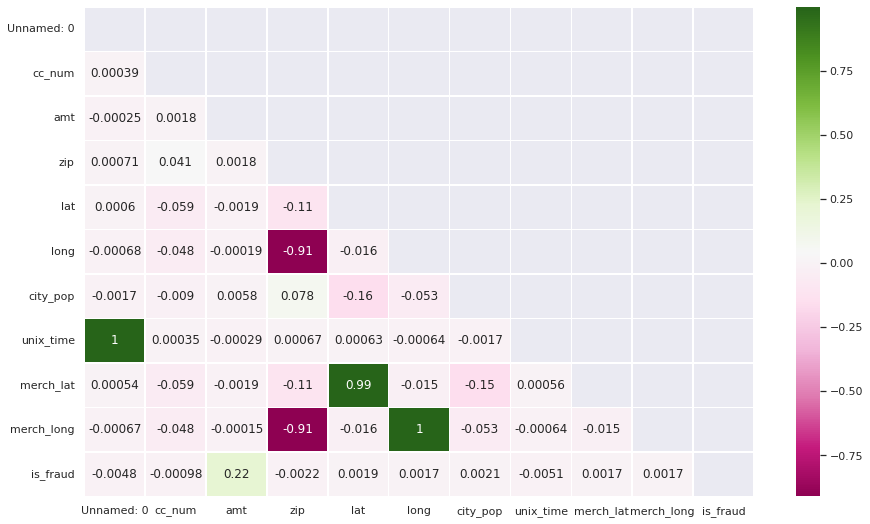

In [ ]:
#Correlation Matrix of Training Data
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap ='PiYG', mask=matrix)
plt.show()

In [ ]:
print(df.shape)
print(df_test.shape)
#1296675 entries, 23 columns (RAW)
print(555719 / (555719+1296675) * 100)
# test size is 30%

(1296675, 23)
(555719, 23)
30.000043187356468


In [ ]:
# df['start_num'] = df['cc_num'].astype(str).str[0]

# start_order = df[df["is_fraud"]==1]['start_num'].value_counts().index
# sns.histplot(data = df,x = 'start_num', hue = 'is_fraud', multiple="stack")
# plt.show()

# Simple Data Cleaning

In [ ]:
# identifying the categorical and numerical features based on their meaning
cat_var = ['category', 'gender', 'job', 'state', 'city', 'street']
numerical_variables = ['amt', 'lat','long', 'city_pop', 'zip', 'merch_lat', 'merch_long', 'unix_time']

df[numerical_variables].describe()

,amt,lat,long,city_pop,zip,merch_lat,merch_long,unix_time
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,7.035104e+01,3.853762e+01,-9.022634e+01,8.882444e+04,4.880067e+04,3.853734e+01,-9.022646e+01,1.349244e+09
std,1.603160e+02,5.075808e+00,1.375908e+01,3.019564e+05,2.689322e+04,5.109788e+00,1.377109e+01,1.284128e+07
min,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,1.257000e+03,1.902779e+01,-1.666712e+02,1.325376e+09
25%,9.650000e+00,3.462050e+01,-9.679800e+01,7.430000e+02,2.623700e+04,3.473357e+01,-9.689728e+01,1.338751e+09
50%,4.752000e+01,3.935430e+01,-8.747690e+01,2.456000e+03,4.817400e+04,3.936568e+01,-8.743839e+01,1.349250e+09
75%,8.314000e+01,4.194040e+01,-8.015800e+01,2.032800e+04,7.204200e+04,4.195716e+01,-8.023680e+01,1.359385e+09
max,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,9.978300e+04,6.751027e+01,-6.695090e+01,1.371817e+09


In [ ]:
#Overview of all columns
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
#Check number of unique numbers
df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [ ]:
#See if there is any duplicated records
df.duplicated().sum()

0

In [ ]:
#Check number of Null/NaN entries
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Feature Engineering

In [ ]:
def feature_engineer(dataframe):
    # #Convert time stamp of type string trans_date_trans_time to date/time 
    # # age = current year - year of birth
    dataframe['age']= dt.date.today().year - pd.to_datetime(df['dob']).dt.year

    # hour taken from trans_date_trans_time
    dataframe['hour'] = pd.to_datetime(dataframe['trans_date_trans_time']).dt.hour

    # day taken from trans_date_trans_time
    dataframe['day'] = pd.to_datetime(dataframe['trans_date_trans_time']).dt.dayofweek

    # day taken from trans_date_trans_time
    #df['day'] = pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
    dataframe['day_name'] = pd.to_datetime(dataframe['trans_date_trans_time']).dt.day_name()

    # month taken from trans_date_trans_time
    dataframe['month'] = pd.to_datetime(dataframe['trans_date_trans_time']).dt.month

    # year taken from trans_date_trans_time
    dataframe['year'] = pd.to_datetime(dataframe['trans_date_trans_time']).dt.year #2019, 2020


In [ ]:
#Feature Engineer the dataframes for test and training
feature_engineer(df)
feature_engineer(df_test)

In [ ]:
#Removing irrelevant Features and variables which have undergone feature engineering
df = df.drop(['Unnamed: 0', 'cc_num', 'dob', 'trans_date_trans_time', 'first', 'last'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'cc_num', 'dob', 'trans_date_trans_time', 'first', 'last'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  object 
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   gender      1296675 non-null  object 
 4   street      1296675 non-null  object 
 5   city        1296675 non-null  object 
 6   state       1296675 non-null  object 
 7   zip         1296675 non-null  int64  
 8   lat         1296675 non-null  float64
 9   long        1296675 non-null  float64
 10  city_pop    1296675 non-null  int64  
 11  job         1296675 non-null  object 
 12  trans_num   1296675 non-null  object 
 13  unix_time   1296675 non-null  int64  
 14  merch_lat   1296675 non-null  float64
 15  merch_long  1296675 non-null  float64
 16  is_fraud    1296675 non-null  int64  
 17  age         1296675 non-null  int64  
 18  hour        1296675 no

# Exploratory Data Analysis (EDA)

In this section, we perform EDA to get an understanding of which variables are important, view summary statistics, and visualize the data.

0    1289169
1       7506
Name: is_fraud, dtype: int64


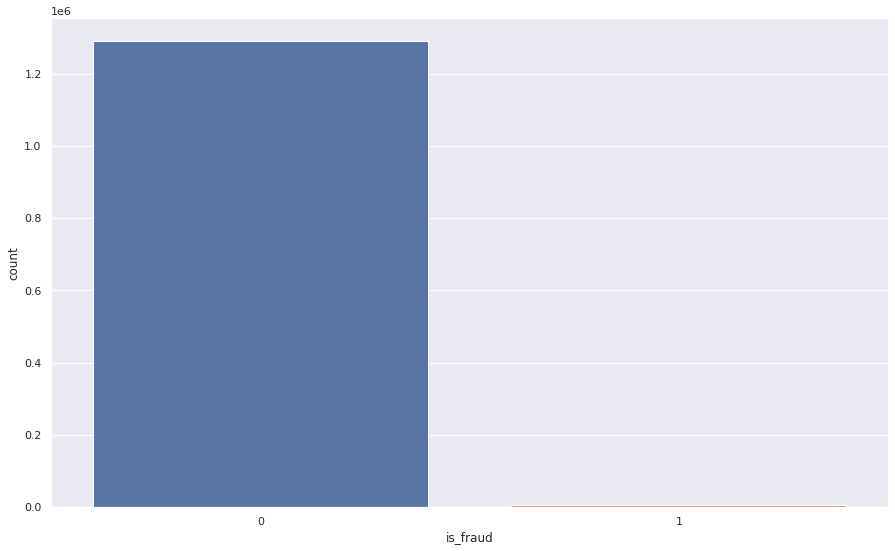

In [ ]:
# Since we will be predicting is_fraud, we create a countplot to visualize the number of fraud and non-frauds as below.
sns.countplot(x='is_fraud', data = df)

print(df.is_fraud.value_counts())
# As we can observe, this fraud dataset is imbalanced, only less than 0.6% of the samples are fraudulent

In [ ]:
# Re-define numerical variables after feature engineering
numerical_variables = ['amt', 'lat','long', 'city_pop', 'zip', 'merch_lat', 'merch_long', 'unix_time', 'age', 'day', 'month', 'hour']

# Quantile Statistics
quantile = df[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
amt,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04,2.894790e+04,7.349000e+01
lat,2.002710e+01,3.462050e+01,3.935430e+01,4.194040e+01,6.669330e+01,4.666620e+01,7.319900e+00
long,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01,9.772200e+01,1.664000e+01
city_pop,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06,2.906677e+06,1.958500e+04
zip,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04,9.852600e+04,4.580500e+04
merch_lat,1.902779e+01,3.473357e+01,3.936568e+01,4.195716e+01,6.751027e+01,4.848248e+01,7.223592e+00
merch_long,-1.666712e+02,-9.689728e+01,-8.743839e+01,-8.023680e+01,-6.695090e+01,9.972034e+01,1.666048e+01
unix_time,1.325376e+09,1.338751e+09,1.349250e+09,1.359385e+09,1.371817e+09,4.644080e+07,2.063463e+07
age,1.700000e+01,3.500000e+01,4.700000e+01,6.000000e+01,9.800000e+01,8.100000e+01,2.500000e+01
day,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00


In [ ]:
# Descriptive Statistics
descriptive_stats = df[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = df[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(df[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(df[x], fisher=False) for x in numerical_variables]
descriptive_stats['excess kurtosis'] = [stats.kurtosis(df[x], fisher=True) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(df[x]) for x in numerical_variables]
descriptive_stats

,mean,std,median,mode,mad,kurtosis,excess kurtosis,skewness
amt,7.035104e+01,1.603160e+02,4.752000e+01,1.140000e+00,3.750000e+01,4548.627447,4545.627447,42.277825
lat,3.853762e+01,5.075808e+00,3.935430e+01,3.638500e+01,3.359700e+00,3.812960,0.812960,-0.186027
long,-9.022634e+01,1.375908e+01,-8.747690e+01,-9.807270e+01,8.152700e+00,4.855881,1.855881,-1.150106
city_pop,8.882444e+04,3.019564e+05,2.456000e+03,6.060000e+02,2.198000e+03,40.614370,37.614370,5.593847
zip,4.880067e+04,2.689322e+04,4.817400e+04,7.375400e+04,2.306800e+04,1.903550,-1.096450,0.079681
merch_lat,3.853734e+01,5.109788e+00,3.936568e+01,3.264469e+01,3.397536e+00,3.795986,0.795986,-0.181915
merch_long,-9.022646e+01,1.377109e+01,-8.743839e+01,-8.711641e+01,8.227889e+00,4.848467,1.848467,-1.146959
unix_time,1.349244e+09,1.284128e+07,1.349250e+09,1.335111e+09,1.035881e+07,1.912459,-1.087541,0.003378
age,4.874255e+01,1.737848e+01,4.700000e+01,5.000000e+01,1.200000e+01,2.823650,-0.176350,0.612358
day,3.070604e+00,2.198153e+00,3.000000e+00,0.000000e+00,2.000000e+00,1.554952,-1.445048,-0.078453


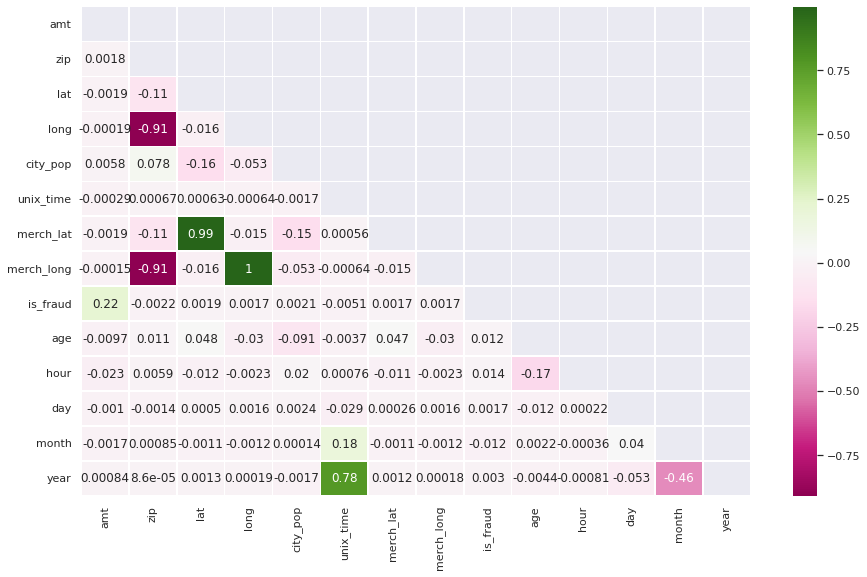

In [ ]:
# Exploring Correlation between the continuous feature variables using correlation heatmap
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap ='PiYG', mask=matrix)
plt.show()
# We can see that the feature amt is correlated with is_fraud

We can notice from this correlation heatmap that there is almost perfect correlation between some features.

Based on contextual information on the features, it makes sense for `long` and `zip`, `merch_long` and `zip`, `merch_lat` and `lat`, `merch_long` and `long` to have the almost perfect correlation relationship. They all represent information on the location.

Therefore, there is duplicate information here, and we can omit some features so as to improve computational efficiency in the later parts.

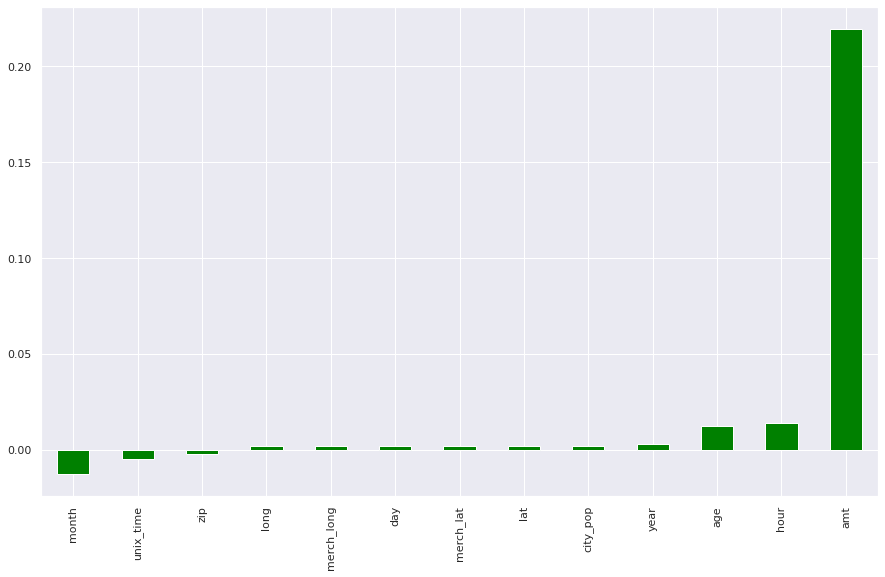

In [ ]:
# Creating a bar plot showing the correlation of the numeric features to is_fraud
df.corr()['is_fraud'].sort_values().drop('is_fraud').plot(kind='bar', color = 'green')

We can observe from this plot that features including `amt`, `hour`, `age`, and `month` have greater correlation with `is_fraud`. In the following EDA, we can focus more on these features, plus exploring the categorical features.

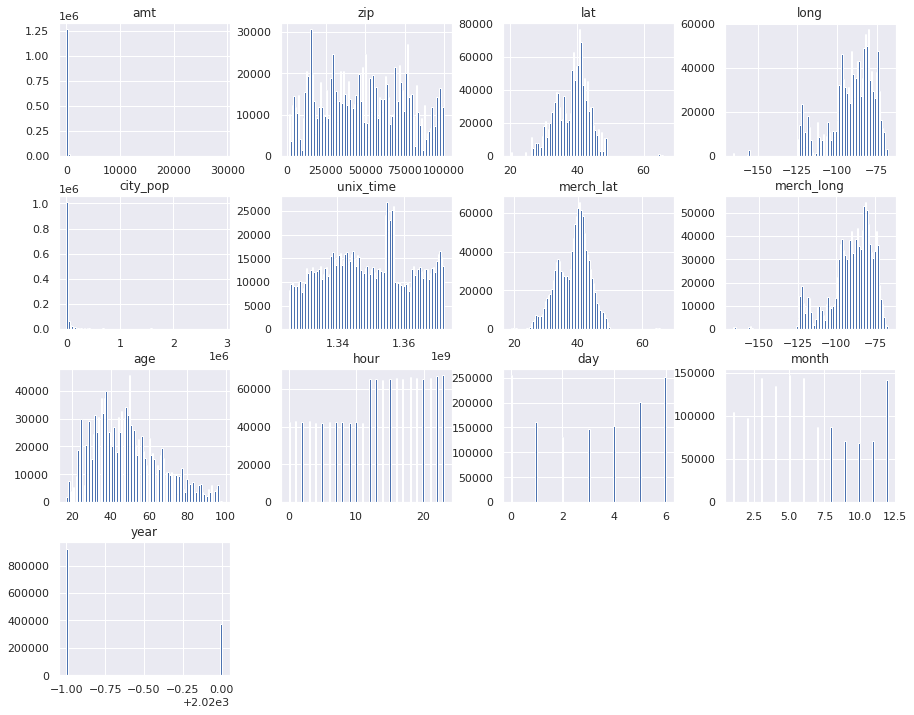

In [ ]:
# plot histogram of features to observe anything unusual
ax = df.drop("is_fraud", axis=1).hist(figsize=(15,12),bins=100)
# We hide the axes' labels to make the plot neater and more compact
# for axis in ax.flatten():
#     axis.set_xticklabels([])
#     axis.set_yticklabels([])

**Exploring feature: Transaction amount 'amt'**

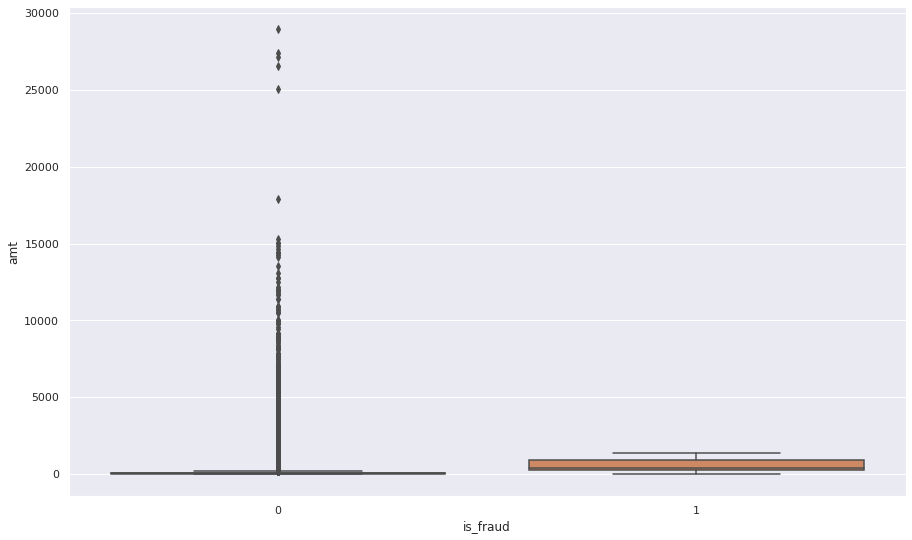

In [ ]:
# create a boxplot showing the relationship between `amt` and `is_fraud`
sns.boxplot(x='is_fraud', y='amt', data=df)

From the above analysis of `amt`, we can see that the typical spending of a fraud transaction is significantly higher than non-fraudulent transactions. Fraudulent transactions values also have a greater standard deviation and inter-quantile range than non-frauds. Non-fraudulent transactions also tend to have outliers with larger amounts.

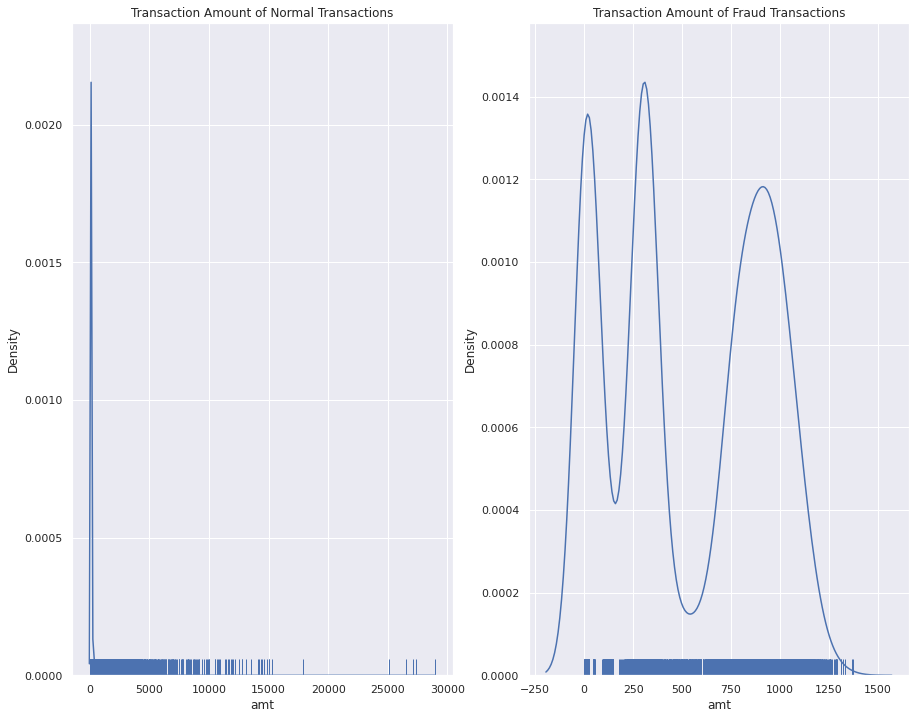

In [ ]:
# explore the amount of transactions for both normal and fraudulent 

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 12))
ax1.set_title('Transaction Amount of Normal Transactions')
ax2.set_title('Transaction Amount of Fraud Transactions')
sns.distplot(df[df["is_fraud"]==0]['amt'], hist = False, rug = True, ax=ax1)
sns.distplot(df[df["is_fraud"]==1]['amt'], hist = False, rug = True, ax=ax2)
plt.show()

# We can observe that for normal transactions, most transaction amount are small, but the range is large
# while for fraudulent transactions, the distribution of amount is irregular, with smaller amount range.

Since the distribution of fraudulent and normal transactions are very different and thus difficult to be observed on one visualisation, we observe them using different ranges as below.

In [ ]:
# Calculate summary statistics for `amt` when comparing between non-fraud vs fraud transactions 
df.groupby('is_fraud')['amt'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


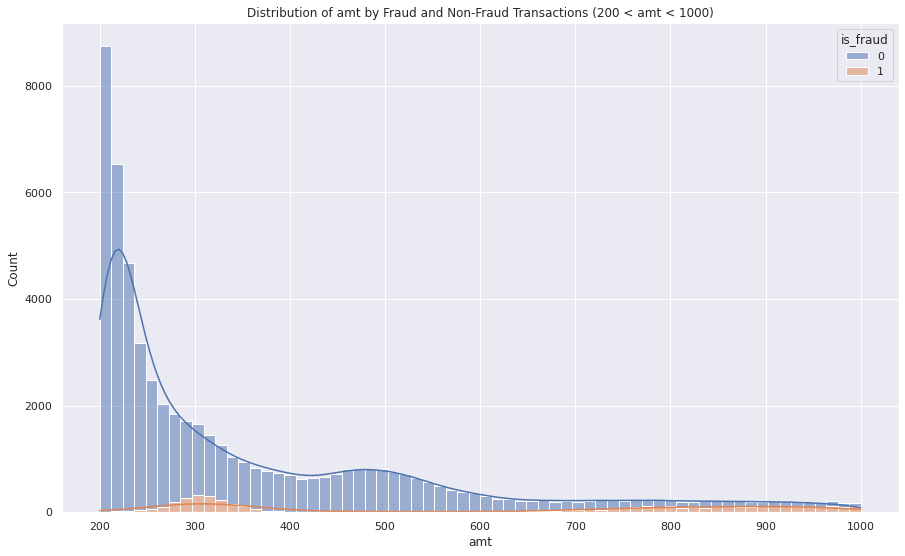

In [ ]:
# When considering the range from SD and mean (200 to 1000)
sns.histplot(data = df[(df['amt'] >= 200) & (df['amt'] <= 1000)],x = 'amt', hue = 'is_fraud', kde = True, multiple="stack")
plt.title("Distribution of amt by Fraud and Non-Fraud Transactions (200 < amt < 1000)")
plt.show()
# Based on the graph below, we can see 2 segments (humps) of fraud transactions with different amount ranges

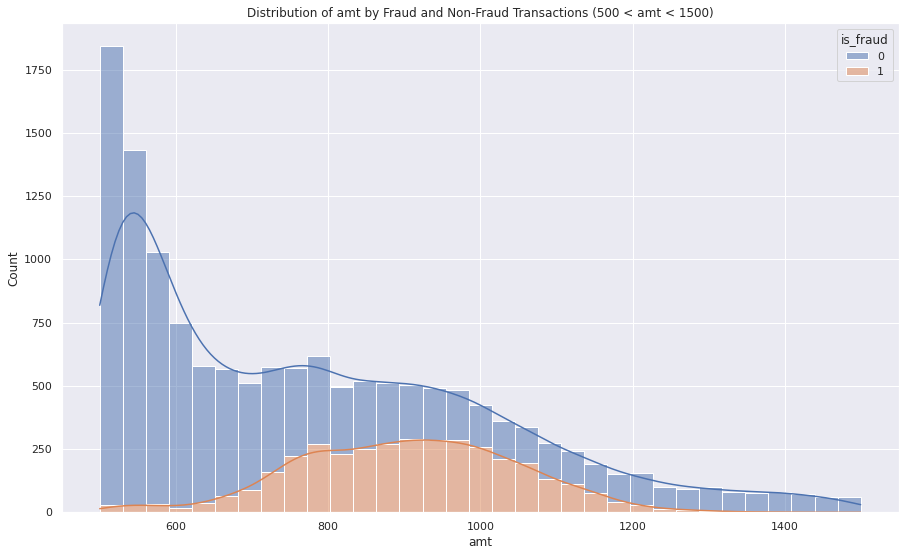

In [ ]:
#When considering the range from SD and mean (500 to 1500)
sns.histplot(data = df[(df['amt'] >= 500) & (df['amt'] <= 1500)],x = 'amt', hue = 'is_fraud', kde = True, multiple="stack")
plt.title("Distribution of amt by Fraud and Non-Fraud Transactions (500 < amt < 1500)")
plt.show()
# Fraud transactions focused mainly in a small range between 800 and 1000

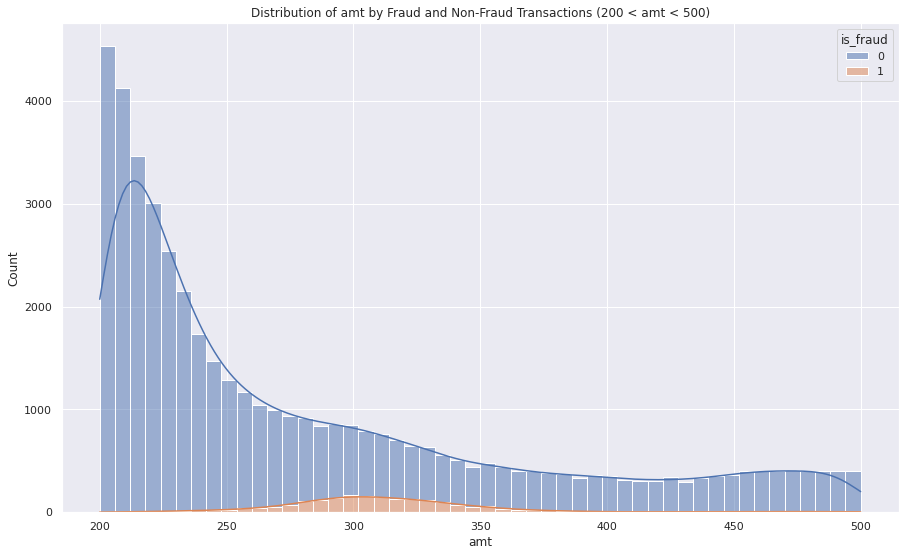

In [ ]:
#Exploring the peak in frauds around (200 to 500)
sns.histplot(data = df[(df['amt'] >= 200) & (df['amt'] <= 500)],x = 'amt', hue = 'is_fraud', kde = True, multiple="stack")
plt.title("Distribution of amt by Fraud and Non-Fraud Transactions (200 < amt < 500)")
plt.show()

We observe extreme outliers in transaction amount.

Transaction amount range [1.0, 28948.9], with a mean at 70.35

To fix this, we can apply the following:

1.   Transform 'amt' into a categorical data. Risk losing information
2.   Transform 'amt' into standardized form using sklearn

For this report, we have decided to apply the first pointer, and transform 'amt' into a categorical data.


In [ ]:
#First we randomly initiate bins to check the distribution of 'amt'
#using bins[0,200,400,600,800,1000,30000]

category1 = pd.cut(df.amt, bins=[0,200,400,600,800,1000,30000], 
                  labels=["0 to 200","201 to 400", "401 to 600", "601 to 800", "801 to 1000", "1001 and above"])
category1.value_counts(normalize=True)

0 to 200          0.952244
201 to 400        0.031022
401 to 600        0.008194
1001 and above    0.003035
601 to 800        0.002973
801 to 1000       0.002531
Name: amt, dtype: float64

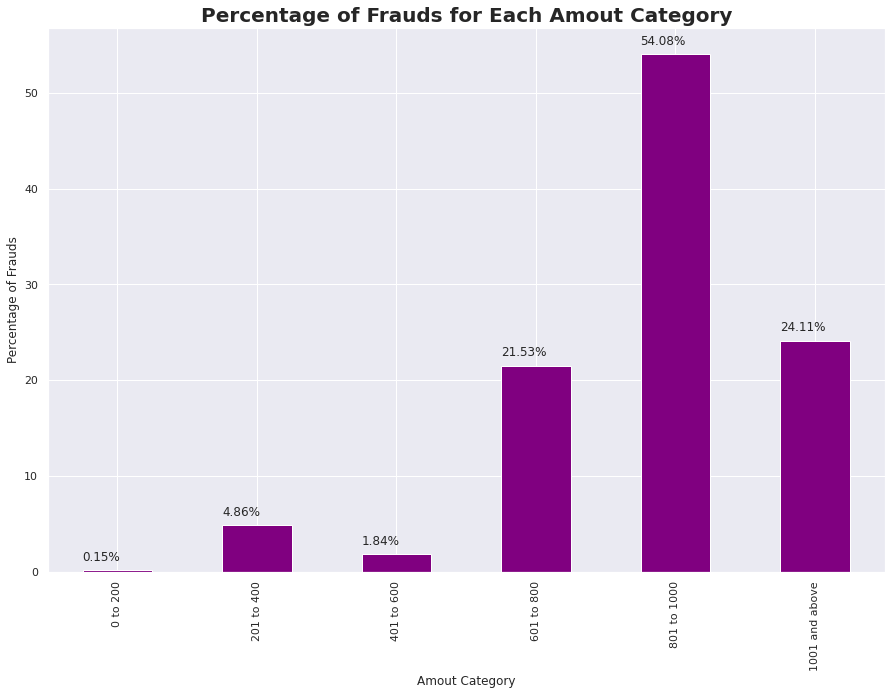

In [ ]:
# try the above category, plot the percentage of frauds in each category
df['cat_amt'] = category1

plt.figure(figsize=(15, 10))
ax = (df[df['is_fraud'] == 1].groupby(['cat_amt']).size() / df.groupby(['cat_amt']).size() * 100).plot(kind='bar', color = 'purple')
plt.xlabel('Amout Category')
plt.ylabel('Percentage of Frauds')
plt.title('Percentage of Frauds for Each Amout Category', fontsize = 20, fontweight = 'bold')

for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2))+"%")
plt.show()

In [ ]:
# As shown above, there are only a few transactions beyond 200 (95.224% falls within 0 - 200), 
# while the percentage of fraudulent transactions below 200 is the lowest (0.15%).
# We try re-categorise the bins. 
category2 = pd.cut(df.amt, bins=[0,50,100,150,200,30000], 
                  labels=["0 to 50","51 to 100", "101 to 150", "151 to 200", "200 and above"])
# category2 = pd.cut(df.amt, bins=[0,50,200,600,800,900,1000,30000], 
#                   labels=["0 to 50","51 to 200", "201 to 600", "601 to 800", "801 to 900", "901 to 1000", "1000 and above"])

category2.value_counts(normalize=True)

0 to 50          0.518479
51 to 100        0.300371
101 to 150       0.098467
200 and above    0.047756
151 to 200       0.034927
Name: amt, dtype: float64

In [ ]:
# We will apply the bin above
df['cat_amt'] = category2
df_test["cat_amt"] = category2

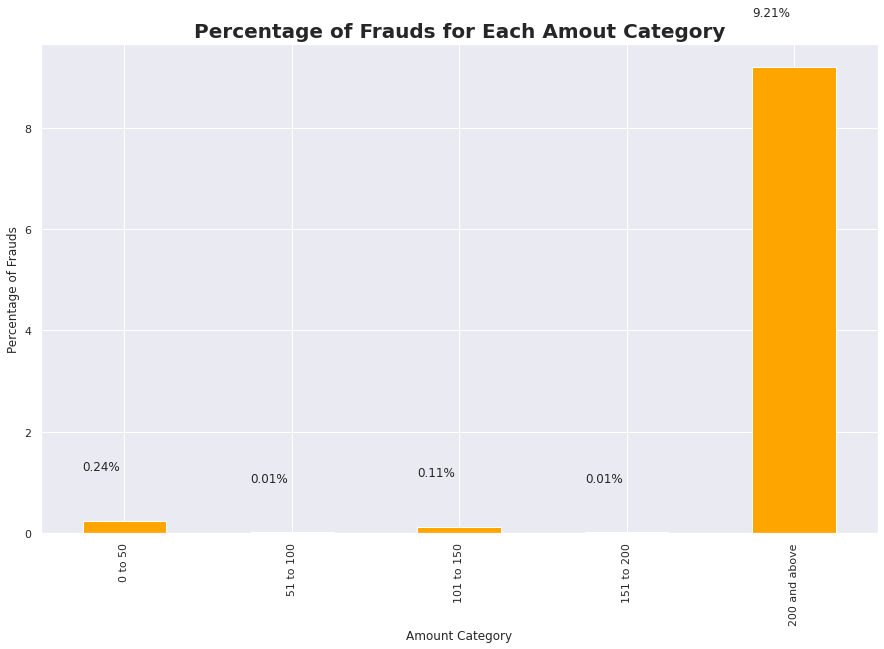

In [ ]:
# For better visualisation, we plot the percentage of frauds for each amount category.
ax = (df[df['is_fraud'] == 1].groupby(['cat_amt']).size() / df.groupby(['cat_amt']).size() * 100).plot(kind='bar', color = 'orange')
plt.xlabel('Amount Category')
plt.ylabel('Percentage of Frauds')
plt.title('Percentage of Frauds for Each Amout Category', fontsize = 20, fontweight = 'bold')

for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2))+"%")

# plt.ylim([0, 15])
plt.show()

# We can see that there is a huge disparity in the number of fraud and non-fraud transactions. However, there is a significant amount of fraud transactions within
# the 200 and above category based on the visualisation.

**Exploring feature: 'age'**

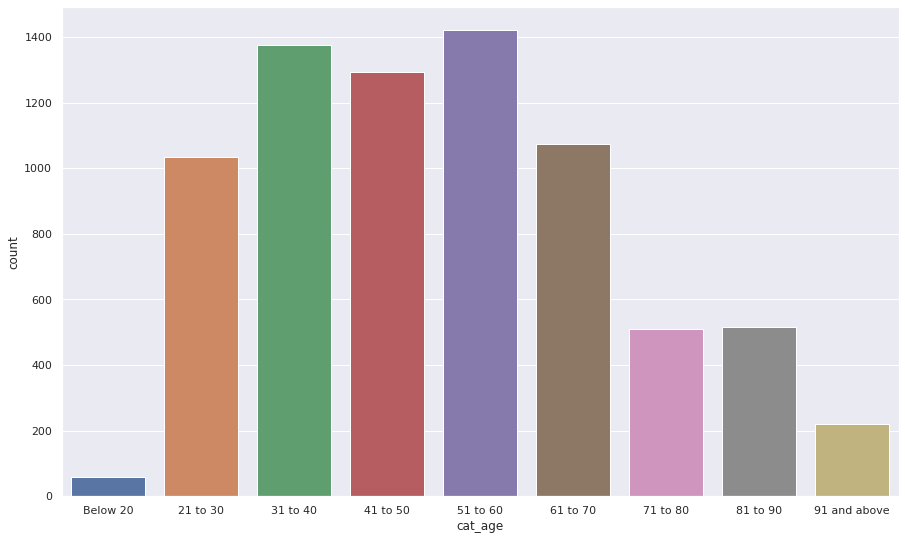

In [ ]:
#Plotting fraud transactions with respect to age group
age_group = pd.cut(df.age, bins=[0,20,30,40,50,60,70, 80, 90, 100], labels=["Below 20", "21 to 30", "31 to 40"
                                                                      , "41 to 50", "51 to 60", "61 to 70", "71 to 80"
                                                                                   , "81 to 90", "91 and above"])
df["cat_age"] = age_group
df_test["cat_age"] = age_group
sns.countplot(x="cat_age",data=df[df["is_fraud"]==1])
plt.show()

# Fraud transactions are more common between 30 to 60 years of old.

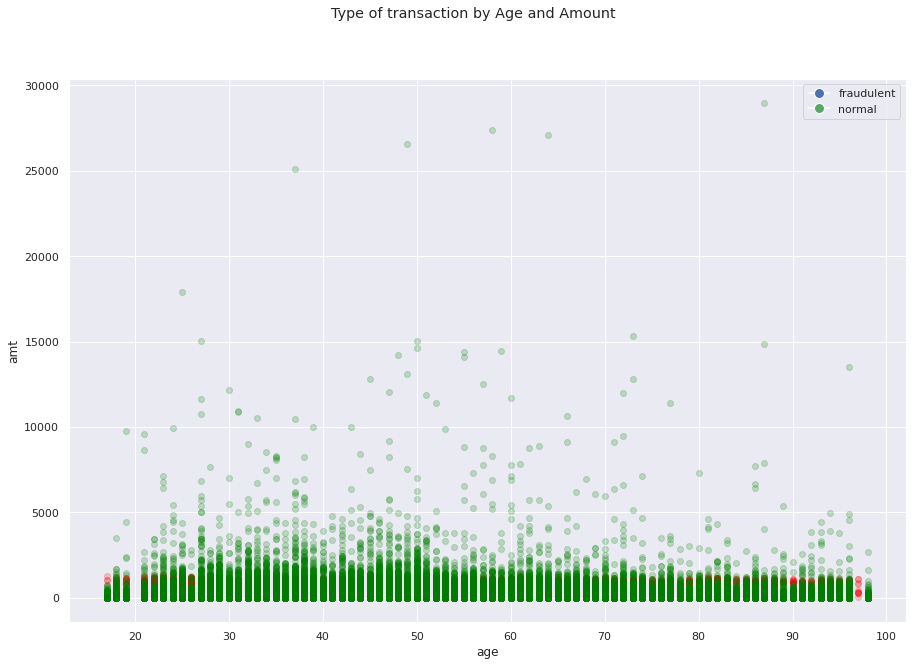

In [ ]:
# To observe the scatter of transaction amount for different ages for both fraudulent & normal transactions
fig, ax = plt.subplots(figsize=(15, 10))
from matplotlib.lines import Line2D
ax.scatter(df[df["is_fraud"]==1]["age"], df[df["is_fraud"]==1]["amt"], c="red", alpha=0.2)
ax.scatter(df[df["is_fraud"]==0]["age"], df[df["is_fraud"]==0]["amt"], c="green", alpha=0.2)
ax.set_xlabel("age")
ax.set_ylabel("amt")
color_patches = [
    Line2D([0], [0], marker='o', color='w', label='fraudulent', markerfacecolor='b', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='normal', markerfacecolor='g', markersize=10)
]
ax.legend(handles=color_patches)
fig.suptitle("Type of transaction by Age and Amount");


**Exploring feature: 'hour' and 'day'**

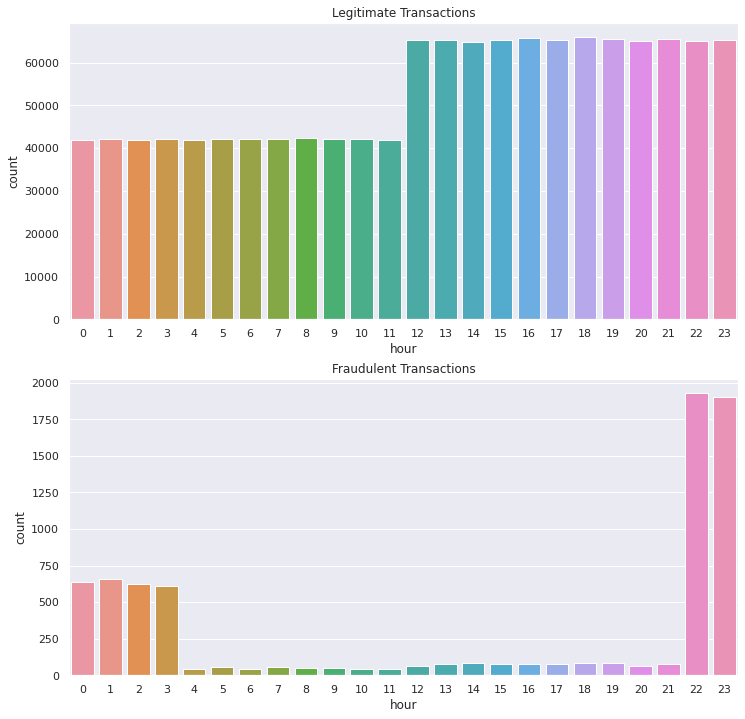

In [ ]:
# Comparing normal and fraudulent transactions with respect to the hour of day

fig, ax = plt.subplots(2, figsize=(12,12))
for a in ax:
    a.set_xticks(range(24))
sns.countplot(x="hour",data=df[df["is_fraud"]==0], ax = ax[0])
sns.countplot(x="hour",data=df[df["is_fraud"]==1], ax = ax[1])
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.show()

# We can observe from these two visualisations that fraudulent transactions are most frequent from 10pm to 3am.

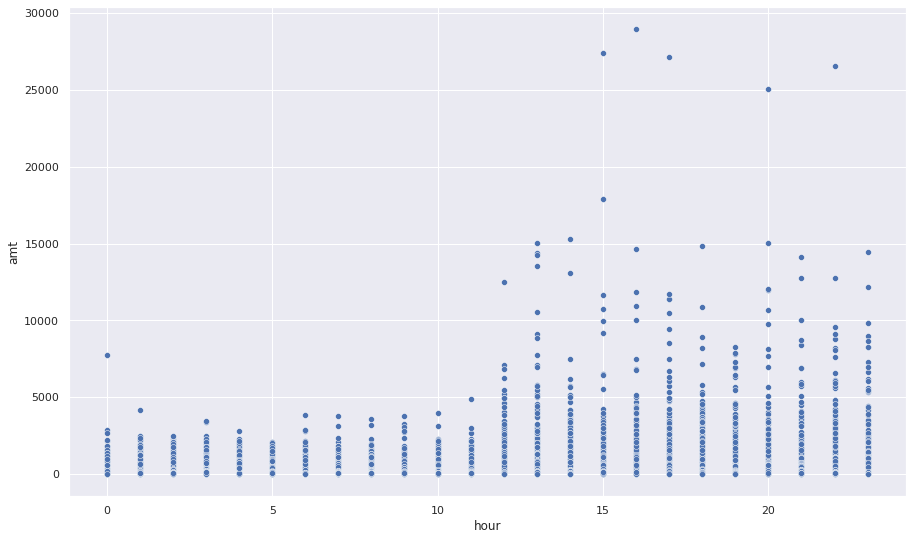

In [ ]:
# To observe whether there is a relationship between transaction hour and transaction amount.
sns.scatterplot(df['hour'], df['amt'])
# We can observe that transaction amount are higher during afternoon to night (12pm - midnight).

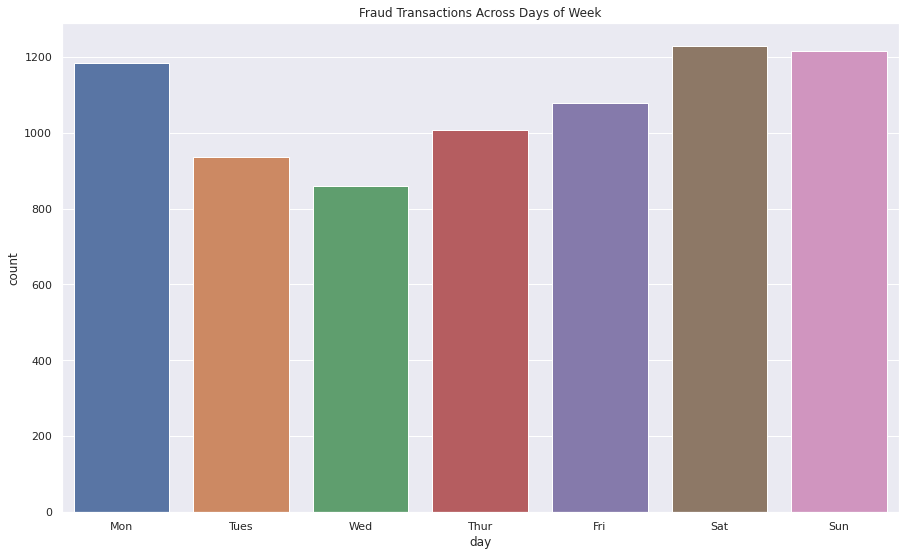

In [ ]:
# Comparing normal and fraudulent transactions with respect to the hour of day
g = sns.countplot(x="day",data=df[df["is_fraud"]==1])
g.set(title = 'Fraud Transactions Across Days of Week')
g.set_xticklabels(['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.show()

**Exploring some categorical features**

In [ ]:
# To see which are the categorical variables in dataset
df.select_dtypes(['object']).columns

Index(['merchant', 'category', 'gender', 'street', 'city', 'state', 'job',
       'trans_num', 'day_name'],
      dtype='object')

In [ ]:
# Explore the feature `gender`  
df['gender'].value_counts()
# There are more transactions done by female customers than male customers.

F    709863
M    586812
Name: gender, dtype: int64

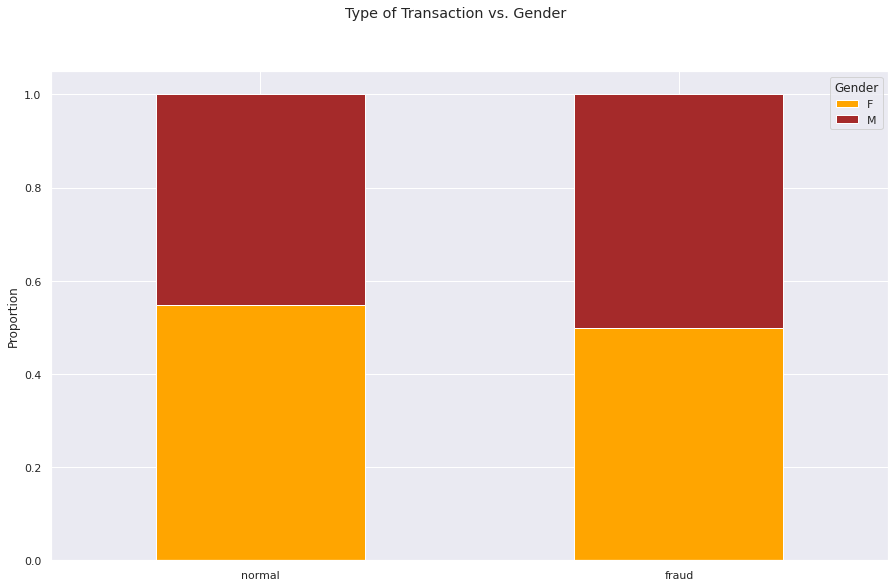

In [ ]:
# type of Transaction vs. Gender
# Divide by the total number and transpose for plotting
counts_df = df.groupby(["gender", "is_fraud"])["trans_num"].count().unstack()
pclass_percents_df = counts_df.div(counts_df.sum()).T
fig, ax = plt.subplots()

pclass_percents_df.plot(kind="bar", stacked=True, color=["orange", "brown"], ax=ax)
ax.legend(title="Gender")
ax.set_xticklabels(["normal", "fraud"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Proportion")
fig.suptitle("Type of Transaction vs. Gender");

# We observe although there are more female customers in total, male customers take up a larger portion in fraudulent transactions.

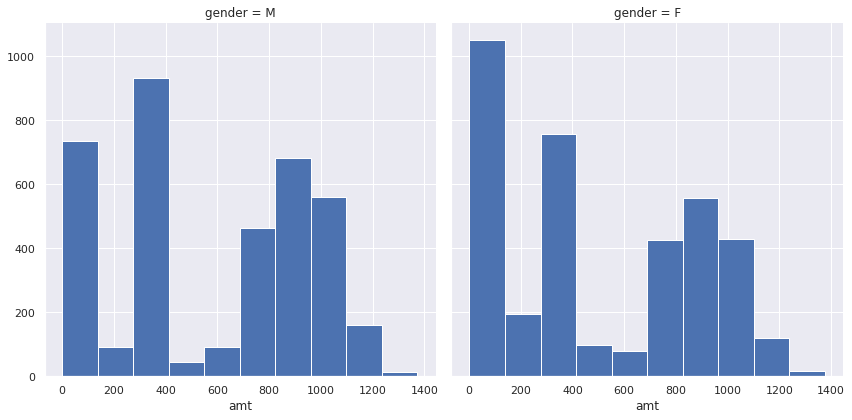

In [ ]:
# observe whether there is a difference in distribution of amount between genders
g = sns.FacetGrid(data = df[df["is_fraud"]==1], col = 'gender', size = 6)
g.map(plt.hist, 'amt')
# We can observe that the distribution of fraudulent transactions amount for both genders are overall similar, with one noticeable difference where
# Female customers have more fraudulent transactions between with amount 0-200.

In [ ]:
# Explore the `state` column - Show the total fraud transaction per state
# showing only the top 15 states since there are in total 51 of them
df.groupby('state')['is_fraud'].sum().sort_values(ascending = False).head(15)

state
NY    555
TX    479
PA    458
CA    326
OH    321
FL    281
IL    248
MI    238
AL    215
MN    207
VA    198
SC    193
MO    191
NE    180
WI    163
Name: is_fraud, dtype: int64

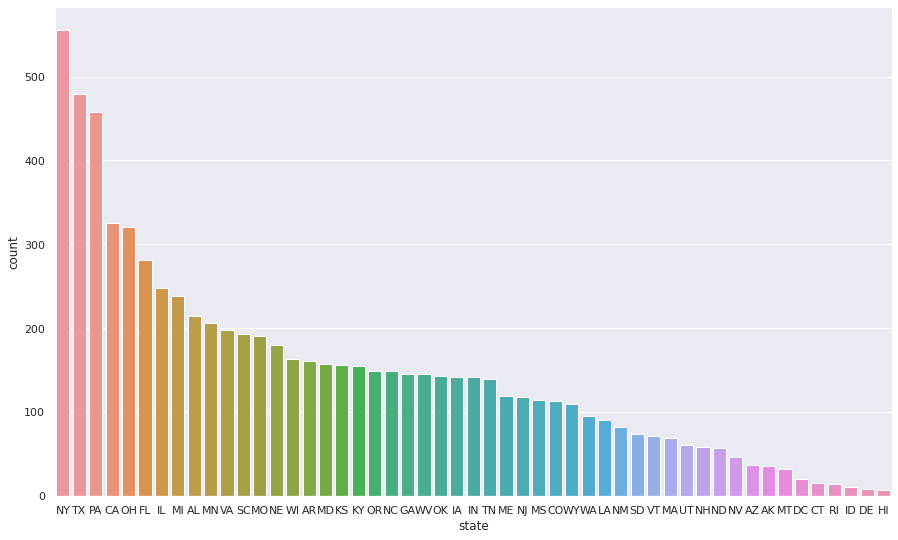

In [ ]:
# Display a count plot of fraud transactions per state
state_order = df[df["is_fraud"]==1]['state'].value_counts().index
sns.countplot(x="state", data=df[df["is_fraud"]==1], order = state_order)
plt.show()

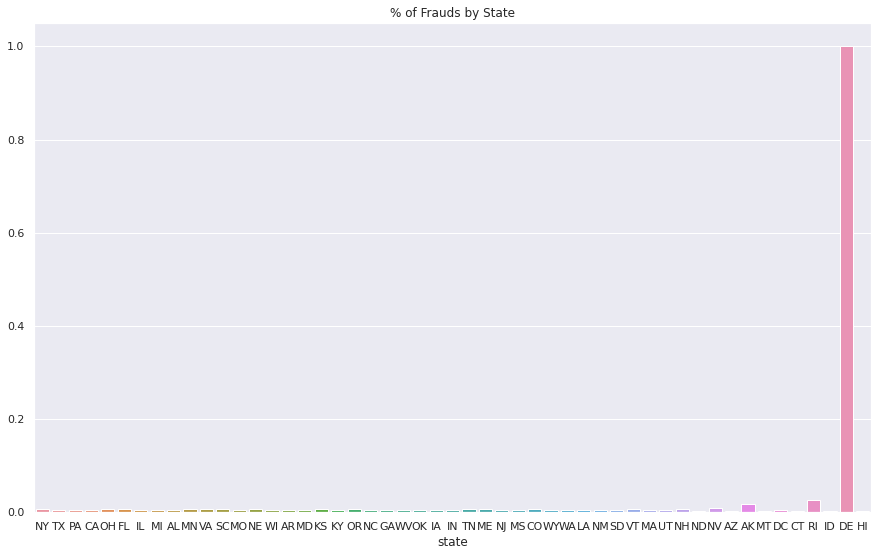

In [ ]:
# Display a count plot of all transactions per state, sorted by the number of fraudulent transactions in each state
state_fraud = df.groupby('state')['is_fraud'].sum()
state_trans = df.groupby('state')['trans_num'].count()
frauds_per_state = state_fraud/state_trans
sns.barplot(y = frauds_per_state, x = frauds_per_state.index, order = state_order).set(title = '% of Frauds by State')
plt.show()
# Here we have an interesting observation that the state DE has a very high fraud rate - almost all transactions in this state is fraudulent.
# Fraud rate in state AK and RI are significantly higher than the rest as well.
# Moreover, states with more frauds don't necessarily have a high fraud rate.

In [ ]:
print(df[df['state']=='DE']['is_fraud'].unique())
# Here we can confirm that all transactions in the state DE is fraudulent.

[1]


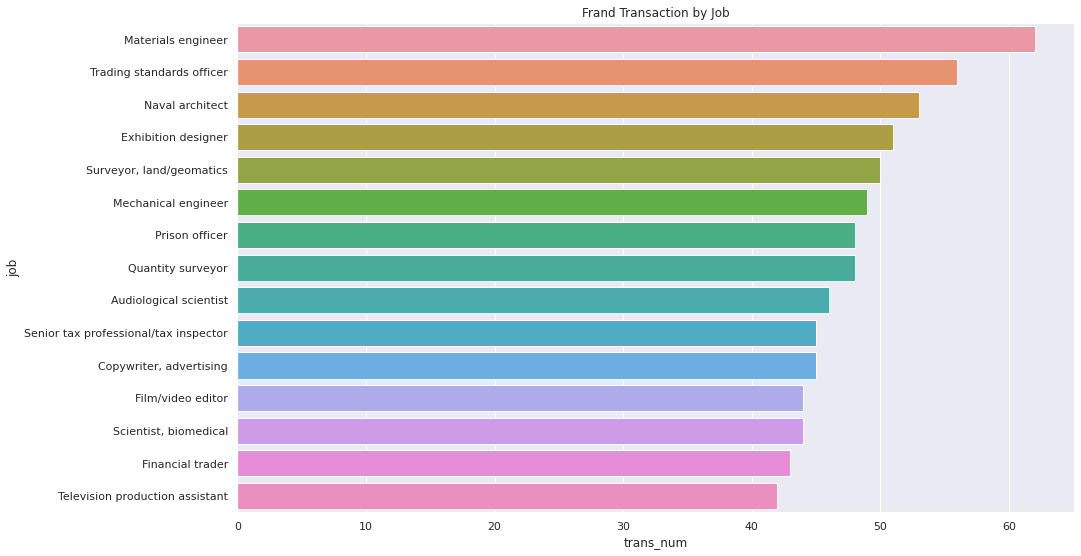

In [ ]:
# Fraud Transactions by Jobs
fraud_jobs = df.groupby(['is_fraud','job']).agg({"amt":'mean',"trans_num":'count'}).reset_index()
job_plot = fraud_jobs[fraud_jobs.is_fraud == 1].sort_values(by = 'trans_num', ascending = False).head(15)
sns.barplot(y = job_plot.job, x = job_plot.trans_num).set(title = 'Frand Transaction by Job')
plt.show()
#The top 5 Jobs are Materials Engineer, Trading standards officer, Naval architect, Exhibition designer, and Surveyor land/geomatics

In [ ]:
sorted(df['category'].unique())

['entertainment',
 'food_dining',
 'gas_transport',
 'grocery_net',
 'grocery_pos',
 'health_fitness',
 'home',
 'kids_pets',
 'misc_net',
 'misc_pos',
 'personal_care',
 'shopping_net',
 'shopping_pos',
 'travel']

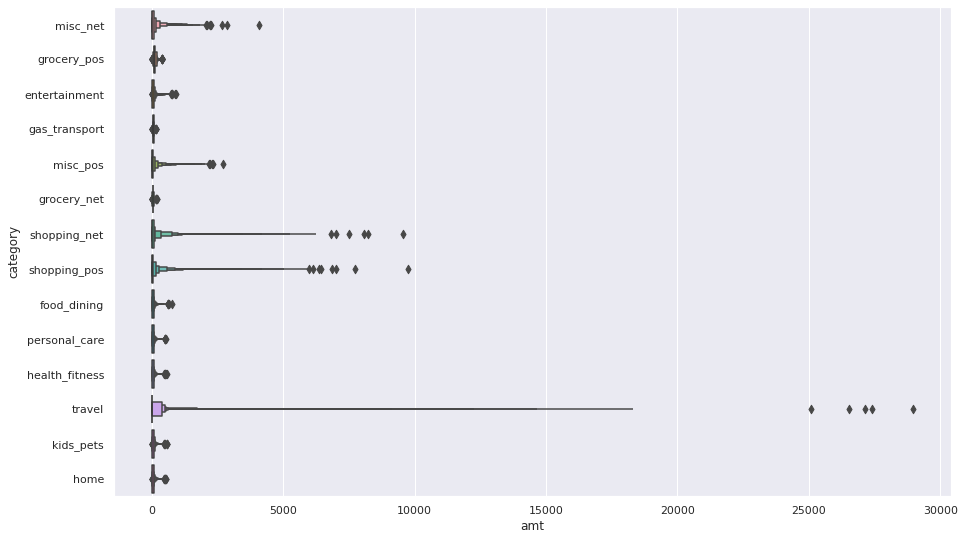

In [ ]:
# amount transacted by category
sns.boxenplot(y = 'category', x = 'amt', data=df )
# We can observe the transactions with highest amounts all fall in category travel
# category shopping_pos, shopping_net, misc_net and misc_pos have higher means of amount

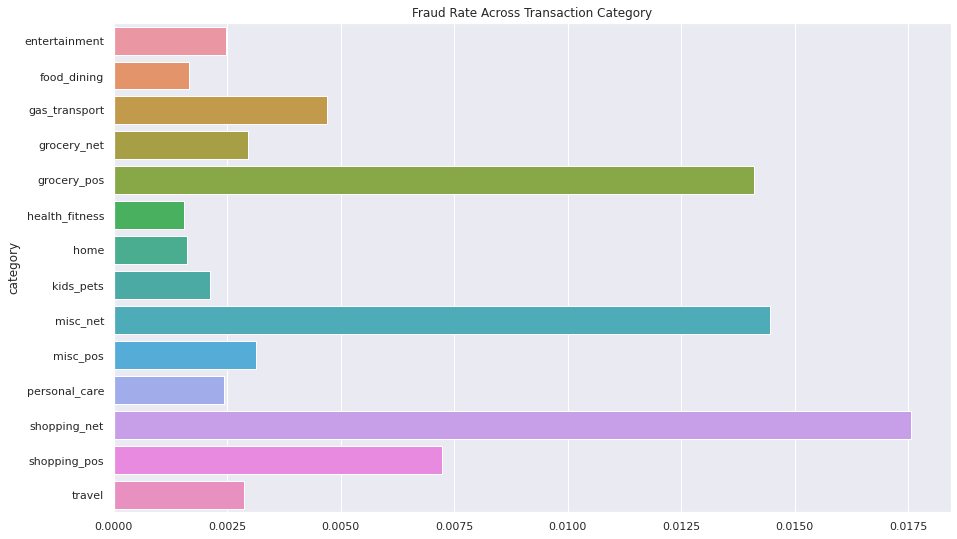

In [ ]:
# Percentage of frauds for each transaction category
category_fraud = df.groupby('category')['is_fraud'].sum()
category_trans = df.groupby('category')['trans_num'].count()
frauds_per_cat = category_fraud/category_trans
sns.barplot(y = frauds_per_cat.index, x = frauds_per_cat).set(title = 'Fraud Rate Across Transaction Category')
plt.show()
# Most frauds seem to be found in shopping_net, misc_net and grocery_pos

**Findings from EDA:**


1.   Fraud transaction mostly happen during the 22 and 23 hour
2.   Fraud mostly happen in New York(NY) and North Carolina(NC)
3.   Fraudulant tranx commonly have 'amt' > 200 - More specifically in 2 different ranges
4. Frauds mostly occur in shopping_net, misc_net and grocery_pos categories
5. Fraud culprits top 5 Jobs are Materials Engineer, Trading standards officer, Naval architect, Exhibition designer, and Surveyor land/geomatics

# Feature Selection and Evaluation

In [ ]:
#Keeping a backup copy before any further feature drops.
backup_df = df.copy()
backup_df_test = df_test.copy()

## Data Preperation with One-Hot Encoding


#### Defining our baseline input features for model and analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   merchant    1296675 non-null  object  
 1   category    1296675 non-null  object  
 2   amt         1296675 non-null  float64 
 3   gender      1296675 non-null  object  
 4   street      1296675 non-null  object  
 5   city        1296675 non-null  object  
 6   state       1296675 non-null  object  
 7   zip         1296675 non-null  int64   
 8   lat         1296675 non-null  float64 
 9   long        1296675 non-null  float64 
 10  city_pop    1296675 non-null  int64   
 11  job         1296675 non-null  object  
 12  trans_num   1296675 non-null  object  
 13  unix_time   1296675 non-null  int64   
 14  merch_lat   1296675 non-null  float64 
 15  merch_long  1296675 non-null  float64 
 16  is_fraud    1296675 non-null  int64   
 17  age         1296675 non-null  int64   
 18  ho

In [ ]:
# For features jobs, street, city, state and merchant, there are too many unique categories to encode them to dummy variable feature, 
# we will not include them in this baseline input features for suitable computational complexity, but will only analyse them in certain capable ML models.

# Baseline training and testing inputs.
# The training and testing inputs X
X = df[['category', 'amt', 'gender', 'city_pop', 'month', 'day', 'hour', 'age', 'lat', 'long']]
X_testing = df_test[['category', 'amt', 'gender', 'city_pop', 'month', 'day', 'hour', 'age', 'lat', 'long']]


In [ ]:
# We will convert `category` into dummy variables and then concatenate the new columns into the original dataframe.
enc = OneHotEncoder()

#One hot encoding for the Training data
feature_array = enc.fit_transform(X[['category']]).toarray()
feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()

#New DF with OHE features
ohe_features = pd.DataFrame(feature_array, columns = feature_labels) 
X_ohe_new = pd.concat([X, ohe_features], axis = 1)


#One hot encoding for the testing data
feature_array_test = enc.fit_transform(X_testing[['category']]).toarray()
feature_labels_test = enc.categories_
feature_labels_test = np.array(feature_labels_test).ravel()

#DF for testing dataset
ohe_features_test = pd.DataFrame(feature_array_test, columns = feature_labels_test) 
X_ohe_new_test = pd.concat([X_testing, ohe_features_test], axis = 1)


In [ ]:
# Encode object type column to integer for modeling
X_ohe_new['gender'] = np.where(X_ohe_new['gender']=="M", 1,0)
X_ohe_new_test['gender'] = np.where(X_ohe_new_test['gender']=="M", 1,0)

In [ ]:
#Defining the y and X values before splitting
#Since we already one-hot encoded `category`, we remove it from the X variables.

#Removing category for train
X_holder = X_ohe_new.copy()
X_holder = X_holder.drop(['category'], axis = 'columns')
X_ohe_new = X_ohe_new.drop(['category'], axis = 'columns').values

#Removing category for test
X_holder_test = X_ohe_new_test.copy()
X_holder_test = X_holder_test.drop(['category'], axis = 'columns')
X_ohe_new_test = X_ohe_new_test.drop(['category'], axis = 'columns').values

y = df['is_fraud'].values
test_y= df_test['is_fraud'].values

In [ ]:
# Check the selected features
X_holder.head()
# X_ohe_new_test.head()

,amt,gender,city_pop,month,day,hour,age,lat,long,entertainment,...,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,4.97,0,3495,1,1,0,34,36.0788,-81.1781,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,107.23,0,149,1,1,0,44,48.8878,-118.2105,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,220.11,1,4154,1,1,0,60,42.1808,-112.2620,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.00,1,1939,1,1,0,55,46.2306,-112.1138,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.96,1,99,1,1,0,36,38.4207,-79.4629,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#Splitting Train-Eval(Validation)-Test data
X_train, X_eval, y_train, y_eval = train_test_split(X_holder, y, test_size=0.15, random_state=0)
#X_null, X_test, y_null, y_test = train_test_split(X_ohe_new_test, testing_y, test_size = 0.3, random_state = 0)

#testing dataset
X_test = X_holder_test
y_test = test_y


print('X_eval: ' + str(X_eval.shape))
print('y_eval: ' + str(y_eval.shape))
print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_test: ' + str(y_test.shape))

X_eval: (194502, 23)
y_eval: (194502,)
X_train: (1102173, 23)
y_train: (1102173,)
X_test: (555719, 23)
y_test: (555719,)


## Imbalanced Dataset

In [ ]:
print(df.is_fraud.value_counts())
# This fraud dataset is also imbalanced, less than 0.6% of the samples are fraudulent

0    1289169
1       7506
Name: is_fraud, dtype: int64



**Imbalanced Dataset**

As fraud datasets are notorious for having imbalance data, with extremely small amount of actual fraudulant case. We will be applying both Oversampling and Undersampling techniques to compare the results.

The purpose of this section is to determine the sampling technique best suited for our dataset and features that can contribute to the models.  

**Oversampling Technique Evaluation**

We will be applying the more advanced over-sampling techniques, original SMOTE, ADASYN and SMOTE variant SMOTENC. The reason for this is that our dataset consist of a mix between categorical and continuous data. SMOTE and ADASYN focuses on sample that are difficult to classify with nearest-neighbors rule. 

The difference being ADASYN focuses on generating samples next to the original samples which are wrongly classified using a K-Nearest Neighbor classifier while SMOTE doesn't make that distinction between easy and hard sample. 

**If we have time**
While SMOTE comes with different variants, our group have decided to test SMOTENC which is recommended in the documentation for handling dataset consisting of both categorical and continuous feature. 

Therefore, we will be evaluating 3 oversampling techniques:

1.   ADASYN
2.   SMOTE
3.   SMOTENC

Documentation: https://imbalanced-learn.org/stable/index.html  



To avoid training data leakage, oversampling is performed only on the training dataset after train-test split. This is to prevent training data overlapping with testing data after oversampling, and affects our evaluation of model performance.

In [ ]:
#SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

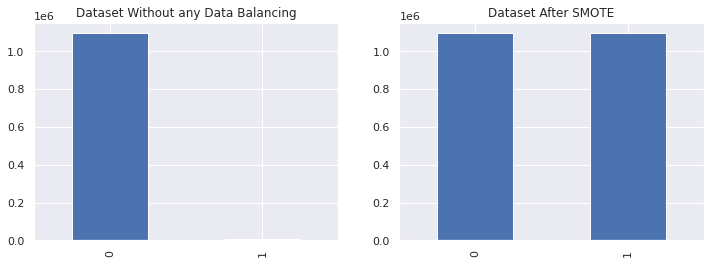

In [ ]:
# No balance vs SMOTE
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(12, 4))
ax1.set_title('Dataset Without any Data Balancing')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)
ax2.set_title('Dataset After SMOTE')
pd.Series(y_train_smote).value_counts().plot.bar(ax=ax2)
plt.show()

In [ ]:
#ADASYN
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)


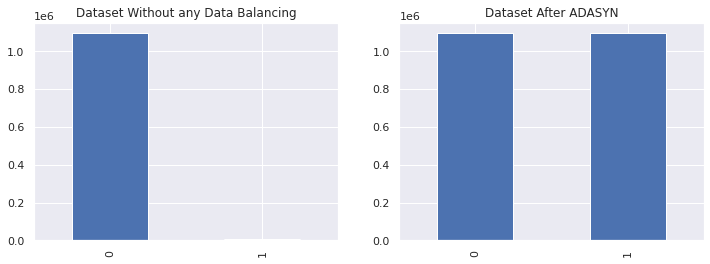

In [ ]:
# No balance vs ADASYN
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(12, 4))
ax1.set_title('Dataset Without any Data Balancing')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)
ax2.set_title('Dataset After ADASYN')
pd.Series(y_train_adasyn).value_counts().plot.bar(ax=ax2)
plt.show()

**Undersampling Technique Evaluation**

Involves removing random records from the majority class, which can cause loss of information.

https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html

2 undersampling techniques:
1. RandomUnderSampler - a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes. Under-sample the majority class(es) by randomly picking samples with or without replacement.

2. NearMiss - Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class. The algorithm does this by looking at the class distribution and randomly eliminating samples from the larger class. When two points belonging to different classes are very close to each other in the distribution, this algorithm eliminates the datapoint of the larger class thereby trying to balance the distribution. 

In [ ]:
#Using RandomUnderSampler
rus = RandomUnderSampler(random_state = 0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


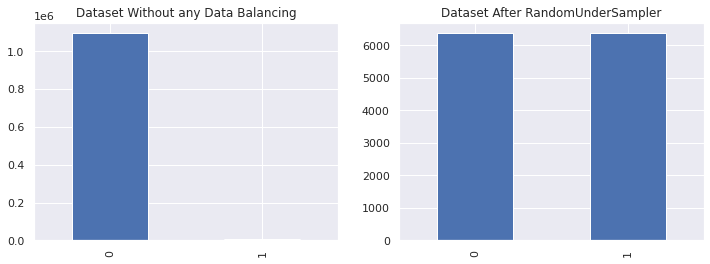

In [ ]:
# No balance vs RandomUnderSampler
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(12, 4))
ax1.set_title('Dataset Without any Data Balancing')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)
ax2.set_title('Dataset After RandomUnderSampler')
pd.Series(y_train_rus).value_counts().plot.bar(ax=ax2)
plt.show()

In [ ]:
# NearMiss
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

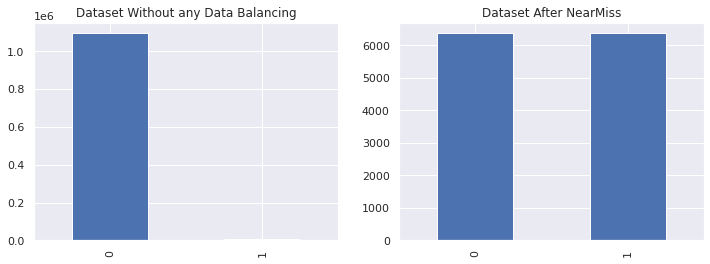

In [ ]:
# No balance vs NearMiss
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(12, 4))
ax1.set_title('Dataset Without any Data Balancing')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)
ax2.set_title('Dataset After NearMiss')  
pd.Series(y_train_nm).value_counts().plot.bar(ax=ax2)
plt.show()

Since there are too many unique job titles to encode them to dummy variable feature, we can remove the job column from the dataset fed in to some of the below machine learning models for suitable computational complexity.

# Machine Learning Models Experiments and Evaluation in Fraud Detection

This section presents the analyses and findings of Logistic Regression, Decision Tree, Random Forest, SVM, XGBoost, and CatBoost on the selected dataset, and the performance of each classifier model for each imbalanced, and balanced dataset after under/over-sampling.

**Feature Selection:**

We will apply various feature evaluation techniques to evaluate the importance of each feature to the model.

**Imbalanced Dataset**

As fraud datasets are notorious for having imbalance data, with extremely small amount of actual fraudulant case. We will be applying both Oversampling and Undersampling techniques to compare the results. 



# Feature scaling

Since some features have much larger values than others in this dataset, in order to avoid the situation where some features are dominated by other features, we apply feature scaling here. This normalization can ensure all features have the same range, and are all considered by the machine learning models.

In [ ]:
#normalization
scaler = StandardScaler()
X_train_log = X_train.copy()
X_eval_log = X_eval.copy()
X_test_log = X_test.copy()

X_smote_log = X_train_smote.copy()
X_adasyn_log = X_train_adasyn.copy()
X_train_rus_log = X_train_rus.copy()
X_train_nm_log = X_train_nm.copy()

#Normalizing for default dataset
X_train_log.iloc[:, :6] = scaler.fit_transform(X_train_log.iloc[:, :6])
X_eval_log.iloc[:, :6] = scaler.transform(X_eval_log.iloc[:, :6])
X_test_log.iloc[:, :6] = scaler.transform(X_test_log.iloc[:, :6])

#Normalizing for Oversampling dataset
X_smote_log.iloc[:, :6] = scaler.fit_transform(X_smote_log.iloc[:, :6])
X_adasyn_log.iloc[:, :6] = scaler.fit_transform(X_adasyn_log.iloc[:, :6])

#Normalzing for UnderSampling dataset
X_train_rus_log.iloc[:, :6] = scaler.fit_transform(X_train_rus.iloc[:, :6])
X_train_nm_log.iloc[:, :6] = scaler.fit_transform(X_train_nm.iloc[:, :6])


In [ ]:
print(X_test_log[:1])

       amt    gender  city_pop     month       day      hour  age      lat  \
0 -0.41839  1.099297  0.810774 -0.041095  1.332866 -0.118756   34  33.9659   

      long  entertainment  ...  grocery_pos  health_fitness  home  kids_pets  \
0 -80.9355            0.0  ...          0.0             0.0   0.0        0.0   

   misc_net  misc_pos  personal_care  shopping_net  shopping_pos  travel  
0       0.0       0.0            1.0           0.0           0.0     0.0  

[1 rows x 23 columns]


As we can observe, after the transformation, the numerical features in our dataset now fall in the same range. This will help with the ML models performance because it can safely be assumed now that all featues contribute equally and are comparable for the range. This especially for models like logistic refression and K nearest neighbors. However, since models which are based on decision trees already have each feature in a node, we do not need to fit transformed data into these models.

# Logistic Regression

Without any Data Balancing

In [ ]:
#DF for collection of results
result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [ ]:
%%time
#LR without any data balancing
lr_model = LogisticRegression()
lr_model.fit(X_train_log,y_train)
lr_predicted = lr_model.predict(X_eval_log)
y_pred_proba = lr_model.predict_proba(X_eval_log)[::,1]

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  y_pred_proba)
auc = roc_auc_score(y_eval, y_pred_proba)
result = result.append({'classifiers': 'no_balance', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

CPU times: user 41.1 s, sys: 16.9 s, total: 58 s
Wall time: 30.9 s


In [ ]:
cm = confusion_matrix(y_true = y_eval, y_pred = lr_predicted)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[193281     90]
 [  1119     12]]


In [ ]:
print(classification_report(y_eval, lr_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    193371
           1       0.12      0.01      0.02      1131

    accuracy                           0.99    194502
   macro avg       0.56      0.51      0.51    194502
weighted avg       0.99      0.99      0.99    194502



In [ ]:
print("Accuracy:", accuracy_score(y_eval,lr_predicted))
print('R2 score:', r2_score(y_eval, lr_predicted))
print('Logloss: ', log_loss(y_eval, lr_predicted))

Accuracy: 0.9937841256131043
R2 score: -0.07521774741032905
Logloss:  0.2146890655377113


With Oversampled data

In [ ]:
%%time
#LR with Oversampling data
#SMOTE
lr_model_sm = LogisticRegression()
lr_model_sm.fit(X_smote_log,y_train_smote)
lr_predicted_sm = lr_model_sm.predict(X_eval_log)
y_pred_proba_sm = lr_model_sm.predict_proba(X_eval_log)[::,1]

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval, y_pred_proba_sm)
auc = roc_auc_score(y_eval, y_pred_proba_sm)
result = result.append({'classifiers': 'SMOTE', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

CPU times: user 1min 12s, sys: 19.9 s, total: 1min 32s
Wall time: 54.9 s


In [ ]:
lr_cm_sm = confusion_matrix(y_true = y_eval, y_pred=lr_predicted_sm)
print('Confusion matrix:\n', lr_cm_sm)

Confusion matrix:
 [[ 81001 112370]
 [    30   1101]]


In [ ]:
print(classification_report(y_eval, lr_predicted_sm))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59    193371
           1       0.01      0.97      0.02      1131

    accuracy                           0.42    194502
   macro avg       0.50      0.70      0.30    194502
weighted avg       0.99      0.42      0.59    194502



In [ ]:
print("Accuracy:", accuracy_score(y_eval,lr_predicted_sm))
print('R2 score:', r2_score(y_eval, lr_predicted_sm))
print('Logloss: ', log_loss(y_eval, lr_predicted_sm))

Accuracy: 0.4221139114250753
R2 score: -98.9623447551042
Logloss:  19.95994034792029


In [ ]:
%%time
#ADASYN
lr_model_ada = LogisticRegression()
lr_model_ada.fit(X_adasyn_log,y_train_adasyn)
lr_predicted_ada = lr_model_ada.predict(X_eval_log)
y_pred_proba_ada = lr_model_ada.predict_proba(X_eval_log)[::,1]

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval, y_pred_proba_ada)
auc = roc_auc_score(y_eval, y_pred_proba_ada)
result = result.append({'classifiers': 'ADASYN', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

CPU times: user 1min 13s, sys: 19.7 s, total: 1min 32s
Wall time: 54.4 s


In [ ]:
lr_cm_ada = confusion_matrix(y_true = y_eval, y_pred=lr_predicted_ada)
print('Confusion matrix:\n', lr_cm_ada)

Confusion matrix:
 [[99807 93564]
 [   64  1067]]


In [ ]:
print(classification_report(y_eval, lr_predicted_ada))

              precision    recall  f1-score   support

           0       1.00      0.52      0.68    193371
           1       0.01      0.94      0.02      1131

    accuracy                           0.52    194502
   macro avg       0.51      0.73      0.35    194502
weighted avg       0.99      0.52      0.68    194502



In [ ]:
print("Accuracy:", accuracy_score(y_eval,lr_predicted_ada))
print('R2 score:', r2_score(y_eval, lr_predicted_ada))
print('Logloss: ', log_loss(y_eval, lr_predicted_ada))

Accuracy: 0.5186270578194568
R2 score: -82.26756596735673
Logloss:  16.626417053997677


With Undersampled data

In [ ]:
%%time
#With RandomUnderSampler

lr_model2 = LogisticRegression()
lr_model2.fit(X_train_rus_log,y_train_rus)
lr_predicted2 = lr_model2.predict(X_eval_log)
y_pred_proba2 = lr_model2.predict_proba(X_eval_log)[::,1]

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  y_pred_proba2)
auc = roc_auc_score(y_eval, y_pred_proba2)
result = result.append({'classifiers': 'RandomUnderSampler', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

CPU times: user 630 ms, sys: 403 ms, total: 1.03 s
Wall time: 571 ms


In [ ]:
cm = confusion_matrix(y_true = y_eval, y_pred=lr_predicted2)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[ 79208 114163]
 [    38   1093]]


In [ ]:
print(classification_report(y_eval, lr_predicted2))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58    193371
           1       0.01      0.97      0.02      1131

    accuracy                           0.41    194502
   macro avg       0.50      0.69      0.30    194502
weighted avg       0.99      0.41      0.58    194502



In [ ]:
print("Accuracy:", accuracy_score(y_eval,lr_predicted2))
print('R2 score:', r2_score(y_eval, lr_predicted2))
print('Logloss: ', log_loss(y_eval, lr_predicted2))

Accuracy: 0.41285436653607677
R2 score: -100.56405456741686
Logloss:  20.27976106938036


In [ ]:
%%time
#With NearMiss()
lr_model3 = LogisticRegression()
lr_model3.fit(X_train_nm_log,y_train_nm)
lr_predicted3 = lr_model3.predict(X_eval_log)
y_pred_proba3 = lr_model3.predict_proba(X_eval_log)[::,1]

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  y_pred_proba3)
auc = roc_auc_score(y_eval, y_pred_proba3)
result = result.append({'classifiers': 'NearMiss', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

CPU times: user 658 ms, sys: 435 ms, total: 1.09 s
Wall time: 662 ms


In [ ]:
cm = confusion_matrix(y_true = y_eval, y_pred=lr_predicted3)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[ 35000 158371]
 [     1   1130]]


In [ ]:
print(classification_report(y_eval, lr_predicted3))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31    193371
           1       0.01      1.00      0.01      1131

    accuracy                           0.19    194502
   macro avg       0.50      0.59      0.16    194502
weighted avg       0.99      0.19      0.30    194502



In [ ]:
print("Accuracy:", accuracy_score(y_eval,lr_predicted3))
print('R2 score:', r2_score(y_eval, lr_predicted3))
print('Logloss: ', log_loss(y_eval, lr_predicted3))

Accuracy: 0.18575644466380808
R2 score: -139.8472994978235
Logloss:  28.12362715169721


In [ ]:
#define metrics
result.set_index('classifiers', inplace=True)

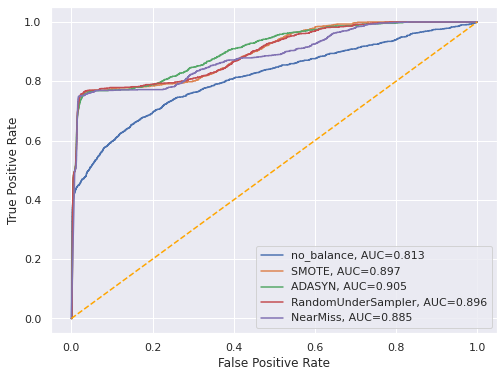

In [ ]:
#create ROC curve
fig = plt.figure(figsize=(8,6))
for i in result.index:
    plt.plot(result.loc[i]['fpr'], 
             result.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Applying Logistic Regression on Testing dataset

In [ ]:
%%time
#Since ADASYN oversampling method provided the best result
#We will use the model that is trained on ADASYN to be used on Testing data

#ADASYN
#Predicting
lr_predicted_ada_test = lr_model_ada.predict(X_test_log)
y_pred_proba_ada_test = lr_model_ada.predict_proba(X_test_log)[::,1]
print(classification_report(y_test, lr_predicted_ada_test))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73    553574
           1       0.01      0.93      0.02      2145

    accuracy                           0.57    555719
   macro avg       0.50      0.75      0.37    555719
weighted avg       1.00      0.57      0.72    555719

CPU times: user 1.56 s, sys: 171 ms, total: 1.73 s
Wall time: 1.57 s


In [ ]:
#ROC metrics
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_ada_test)
auc = roc_auc_score(y_test, y_pred_proba_ada_test)
auc

0.8973190942488634

In [ ]:
print("Accuracy:", accuracy_score(y_test,lr_predicted_ada_test))
print('R2 score:', r2_score(y_test, lr_predicted_ada_test))
print('Logloss: ', log_loss(y_test, lr_predicted_ada_test))

Accuracy: 0.5504112690046589
R2 score: -115.92918628457696
Logloss:  15.528603902103093


# Decision Tree

Decision Trees are a type of Supervised Machine Learning (that is you explain what the input is and what the corresponding output is in the training data) where the data is continuously split according to a certain parameter. The tree can be explained by two entities, namely decision nodes and leaves. The leaves are the decisions or the final outcomes. And the decision nodes are where the data is split.

https://www.xoriant.com/blog/decision-trees-for-classification-a-machine-learning-algorithm#:~:text=Introduction%20Decision%20Trees%20are%20a,namely%20decision%20nodes%20and%20leaves.



In [ ]:
X_train, X_eval, y_train, y_eval
#SMOTE 
method= SMOTE()
dtX_smote, dty_smote = method.fit_resample(X_train, y_train)

#ADASYN
method = ADASYN()
dtX_adasyn, dty_adasyn = method.fit_resample(X_train, y_train)

#Using RandomUnderSampler
rus = RandomUnderSampler(random_state = 0)
dtX_train_rus, dty_train_rus = rus.fit_resample(X_train, y_train)

#Near Miss
nm = NearMiss()
dtX_train_nm, dty_train_nm = nm.fit_resample(X_train, y_train)

#DF for collection of results
dtresult = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

## Determining Best Max_Depth

In [ ]:
#Testing best depth to prevent over/underfittting

# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
dtvalues = [i for i in range(1, 10)]
# evaluate a decision tree for each depth
for i in dtvalues:
	# configure the model
	model = DecisionTreeClassifier(max_depth=i, random_state=0)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_eval)
	test_acc = accuracy_score(y_eval, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(dtvalues, train_scores, '-o', label='Train')
plt.plot(dtvalues, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [ ]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline

## Testing Sampling Methods

In [ ]:
%%time
dt = DecisionTreeClassifier(max_depth=4)

#RF without any data balancing
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_eval)
dty_pred_proba = dt.predict_proba(X_eval)[::,1]

dtcm = confusion_matrix(y_true = y_eval, y_pred = dt_pred)

print('Confusion matrix:\n', dtcm)
print(classification_report(y_eval, dt_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  dty_pred_proba)
auc = roc_auc_score(y_eval, dty_pred_proba)
dtresult = dtresult.append({'classifiers': 'no_balance', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

(1102173,)

In [ ]:
%%time
dtrus = DecisionTreeClassifier(max_depth=4)
#RandomUnderSampler
dtrus.fit(dtX_train_rus, dty_train_rus)
dtrus_pred = dtrus.predict(X_eval)
dtrusy_pred_proba = dtrus.predict_proba(X_eval)[::,1]

dtruscm = confusion_matrix(y_true =y_eval, y_pred = dtrus_pred)

print('Confusion matrix:\n', dtruscm)
print(classification_report(y_eval, dtrus_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  dtrusy_pred_proba)
auc = roc_auc_score(y_eval, dtrusy_pred_proba)
dtresult = dtresult.append({'classifiers': 'Random Under Sampler', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

ValueError: ignored

In [ ]:
%%time
dtnm =DecisionTreeClassifier(max_depth=4)

#NearMiss
dtnm.fit(dtX_train_nm, dty_train_nm)
dtnm_pred = dtnm.predict(X_eval)
dtnmy_pred_proba = dtnm.predict_proba(X_eval)[::,1]

dtnmcm = confusion_matrix(y_true = y_eval, y_pred = dtnm_pred)

print('Confusion matrix:\n', dtnmcm)
print(classification_report(y_eval, dtnm_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  dtnmy_pred_proba)
auc = roc_auc_score(y_eval, dtnmy_pred_proba)
dtresult = dtresult.append({'classifiers': 'Near Miss', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

In [ ]:
%%time
dts = DecisionTreeClassifier(max_depth=4)

#Smote
dts.fit(dtX_smote, dty_smote)
dts_pred = dts.predict(X_eval)
dtsy_pred_proba = dts.predict_proba(X_eval)[::,1]

dtscm = confusion_matrix(y_true = y_eval, y_pred = dts_pred)

print('Confusion matrix:\n', dtscm)
print(classification_report(y_eval, dts_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  dtsy_pred_proba)
auc = roc_auc_score(y_eval, dtsy_pred_proba)
dtresult = dtresult.append({'classifiers': 'Smote', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

In [ ]:
%%time
dtada = dt =DecisionTreeClassifier(max_depth=4)

#ADASYN
dtada.fit(dtX_adasyn, dty_adasyn)
dtada_pred = dtada.predict(X_eval)
dtaday_pred_proba = dtada.predict_proba(X_eval)[::,1]

dtscm = confusion_matrix(y_true = y_eval, y_pred = dtada_pred)

print('Confusion matrix:\n', dtscm)
print(classification_report(y_eval, dtada_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  dtaday_pred_proba)
auc = roc_auc_score(y_eval, dtaday_pred_proba)
dtresult = dtresult.append({'classifiers': 'ADASYN', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

In [ ]:
print("rus: ", accuracy_score(y_test, dtrus.predict(X_test)))
print("nm: ", accuracy_score(y_test, dtnm.predict(X_test)))
print("smote: ", accuracy_score(y_test, dts.predict(X_test)))
print("adasyn: ", accuracy_score(y_test, dtada.predict(X_test)))


## Gridsearch for best hyperparameter tuning


In [ ]:
dt =DecisionTreeClassifier(max_depth=4)
parameters = {'criterion':['gini', 'entropy'], 'max_depth' : [4,6,8,10,12]}
# gsdt = GridSearchCV(dt, parameters)

# gsdt.fit(dtX_adasyn, dty_adasyn)
# print(gsdt.best_estimator_)

In [ ]:
#best Gridsearch estimators
dtt = DecisionTreeClassifier(criterion='gini', max_depth=12)

In [ ]:
%%time

dtt.fit(dtX_adasyn, dty_adasyn)
dtt_pred = dtt.predict(X_test)
dtty_pred_proba = dtt.predict_proba(X_test)[::,1]

dtcm = confusion_matrix(y_true = y_test, y_pred = dtt_pred)

print('Confusion matrix:\n', dtcm)
print(classification_report(y_test, dtt_pred))

#ROC metrics
print('ROC: ', roc_auc_score(y_test, dtty_pred_proba))
print('Accuracy: ', accuracy_score(y_test, dtt_pred))
print('Share of Non-Fraud in Train Data:', 1-round(dty_adasyn.sum()/len(dty_adasyn),4))
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

In [ ]:
dtresult

In [ ]:
#define metrics, comment out if already ran once!
dtresult.set_index('classifiers', inplace=True)

#create ROC curve
fig = plt.figure(figsize=(10,6))
for i in dtresult.index:
    plt.plot(dtresult.loc[i]['fpr'], 
             dtresult.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, dtresult.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Determining and Tweaking Features


In [ ]:
importances = dtt.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title("Feature Importances for Decision Tree")
j = 10
plt.barh(range(j), importances[indices][len(indices)-j:],color='g',align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.show()

In [ ]:
%%time

#segregating top 2 features
best_dt_train = dtX_adasyn[['amt', 'hour']]
best_dt_test =  X_test[['amt', 'hour']]

dtt = DecisionTreeClassifier(criterion='gini', max_depth=12)
dtt.fit(best_dt_train, dty_adasyn)
dtt_pred = dtt.predict(best_dt_test)
dtty_pred_proba = dtt.predict_proba(best_dt_test)[::,1]

dtcm = confusion_matrix(y_true = y_test, y_pred = dtt_pred)

print('Confusion matrix:\n', dtcm)
print(classification_report(y_test, dtt_pred))

#ROC metrics
print('ROC: ', roc_auc_score(y_test, dtty_pred_proba))
print('Accuracy: ', accuracy_score(y_test, dtt_pred))
# ROC:  0.9322868531955303
# Accuracy:  0.9075701928492638

# Random Forest

a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging.

reference link:
https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

## Determining Best Max_Depth

In [ ]:
#DF for collection of results
rf_result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

>1, train: 0.994, test: 0.994
>2, train: 0.994, test: 0.994
>3, train: 0.994, test: 0.994
>4, train: 0.994, test: 0.994
>5, train: 0.995, test: 0.995
>6, train: 0.996, test: 0.996
>7, train: 0.997, test: 0.997


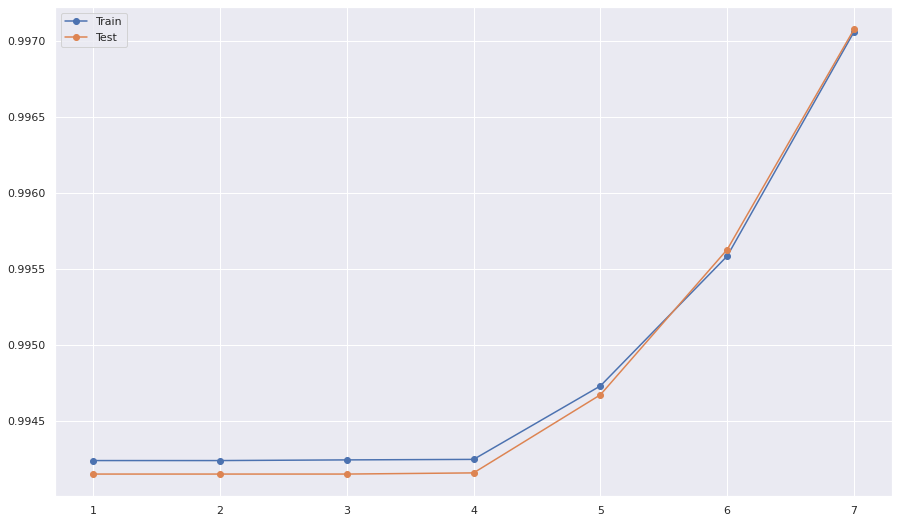

In [ ]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 8)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = RandomForestClassifier(max_depth=i, random_state=0)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

From the first 7 depths, at depth 5 to 6, the training and testing data accuracy overlapped. This means that the data was overfitted at that point. Hence, the max depth of 5 will be used for subsequent models. 

## Testing Sampling Methods
Using a standard number of estimators at 100, the random forests will not enable out-of bag sampling, since a validation data set is used. Additionally, due to the interpritablity of each tree in the random forest, we will not be using the non-balanced sampling for the random forest

In [ ]:
%%time
rfrus = RandomForestClassifier(max_depth=5)

#RF with RandomUnderSampler (Undersampling)
#RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes. Under-sample the majority class(es) by randomly picking samples with or without replacement.

rus = RandomUnderSampler(random_state = 0)

rfrus.fit(dtX_train_rus, dty_train_rus)
rfrus_pred = rfrus.predict(X_eval)
rfrusy_pred_proba = rfrus.predict_proba(X_eval)[::,1]

rfruscm = confusion_matrix(y_true = y_eval, y_pred = rfrus_pred)
print('Confusion matrix:\n', rfruscm)
print(classification_report(y_eval, rfrus_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  rfrusy_pred_proba)
auc = roc_auc_score(y_eval, rfrusy_pred_proba)
rf_result = rf_result.append({'classifiers': 'Random Under Sampler', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

TypeError: ignored

In [ ]:
%%time
rfnm = RandomForestClassifier(max_depth=5)

#RF with NearMiss()
rfnm.fit(dtX_train_nm, dty_train_nm)
rfnmy_pred = rfnm.predict(X_eval)
rfnmy_pred_proba = rfnm.predict_proba(X_eval)[::,1]

rfnmcm = confusion_matrix(y_true = y_eval, y_pred = rfnmy_pred)

print('Confusion matrix:\n', rfnmcm)
print(classification_report(y_eval, rfnmy_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  rfnmy_pred_proba)
auc = roc_auc_score(y_eval, rfnmy_pred_proba)
rf_result = rf_result.append({'classifiers': 'Near Miss', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

In [ ]:
%%time
rfs = RandomForestClassifier(max_depth=5)

#RF with SMOTE (Oversampling)
rfs.fit(dtX_smote, dty_smote)
rfsy_pred = rfs.predict(X_eval)
rfsy_pred_proba = rfs.predict_proba(X_eval)[::,1]

rfscm = confusion_matrix(y_true = y_eval, y_pred = rfsy_pred)

print('Confusion matrix:\n', rfscm)
print(classification_report(y_eval, rfsy_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  rfsy_pred_proba)
auc = roc_auc_score(y_eval, rfsy_pred_proba)
rf_result = rf_result.append({'classifiers': 'SMOTE', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

Confusion matrix:
 [[188259 198468]
 [   215   2061]]
              precision    recall  f1-score   support

           0       1.00      0.49      0.65    386727
           1       0.01      0.91      0.02      2276

    accuracy                           0.49    389003
   macro avg       0.50      0.70      0.34    389003
weighted avg       0.99      0.49      0.65    389003



In [ ]:
%%time
rfada = RandomForestClassifier(max_depth=5)

#RF with ADASYN (Oversampling)
rfada.fit(dtX_adasyn, dty_adasyn)
rfaday_pred = rfada.predict(X_eval)
rfaday_pred_proba = rfada.predict_proba(X_eval)[::,1]

rfadacm = confusion_matrix(y_true = y_eval, y_pred = rfaday_pred)

print('Confusion matrix:\n', rfadacm)
print(classification_report(y_eval, rfaday_pred))

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  rfaday_pred_proba)
auc = roc_auc_score(y_eval, rfaday_pred_proba)
rf_result = rf_result.append({'classifiers': 'ADASYN', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

In [ ]:
print("rus: ", accuracy_score(y_test, rfrus.predict(X_test)))
print("nm: ", accuracy_score(y_test, rfnm.predict(X_test)))
print("smote: ", accuracy_score(y_test, rfs.predict(X_test)))
print("adasyn: ", accuracy_score(y_test, rfada.predict(X_test)))

Amongst all the results, ADASYN has the best accuracy results.

## Gridsearch for best hyperparameter tuning

In [ ]:
rf_result

In [ ]:
%%time
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
n_estimators = [100, 200, 300, 1000]
parameters = dict(criterion=criterion,
                      max_depth=max_depth,
                 n_estimators=n_estimators)
# rft = GridSearchCV(RandomForestClassifier(), parameters)

# rft.fit(dtX_adasyn[0:1000], dty_adasyn[0:1000])
# print(rft.best_estimator_)

In [ ]:
%%time

# Best estimator -> RandomForestClassifier(max_depth=2)
rftt = RandomForestClassifier(max_depth=2)
rftt.fit(dtX_adasyn[0:1000], dty_adasyn[0:1000])
rfty_pred = rftt.predict(X_test)
rfty_pred_proba = rftt.predict_proba(X_test)[::,1]

print(classification_report(y_test, rfty_pred))
print('ROC: ', roc_auc_score(y_test, rfty_pred_proba))
print('Accuracy: ', accuracy_score(y_test, rfty_pred))

## Determining and Tweaking Features

In [ ]:
importances = rftt.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title("Feature Importances for Random Forest")
j = 15
plt.barh(range(j), importances[indices][len(indices)-j:],color='g',align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.show()

In [ ]:
%%time

#segregating top 2 features
best_rf_train = dtX_adasyn.drop(['gender','city_pop','month'],axis=1)
best_rf_test =  X_test.drop(['gender','city_pop','month'],axis=1)

rft = RandomForestClassifier(max_depth=2)
rft.fit(best_rf_train, dty_adasyn)
rft_pred = rft.predict(best_rf_test)
rfty_pred_proba = rft.predict_proba(best_rf_test)[::,1]

dtcm = confusion_matrix(y_true = y_test, y_pred = rft_pred)

print('Confusion matrix:\n', dtcm)
print(classification_report(y_test, rft_pred))

#ROC metrics
print('ROC: ', roc_auc_score(y_test, rfty_pred_proba))
print('Accuracy: ', accuracy_score(y_test, rft_pred))
# ROC:  0.9215574428353569
# Accuracy:  0.9708323811134764

In [ ]:
#define metrics
rf_result.set_index('classifiers', inplace=True)

#create ROC curve
fig = plt.figure(figsize=(10,12))
for i in rf_result.index:
    plt.plot(rf_result.loc[i]['fpr'], 
             rf_result.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, rf_result.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

KeyError: ignored

<Figure size 720x864 with 0 Axes>

# SVM

Model is run using the under sampling methods. 

In [ ]:
%%time

# Undersampling - RandomUnderSampler

model=SVC()

model.fit(X_train_rus_log,y_train_rus)
predicted = model.predict(X_eval_log)

print("Accuracy:", accuracy_score(y_eval, predicted))
print('Classification report:\n', classification_report(y_eval, predicted))

conf_mat = confusion_matrix(y_eval, predicted)
print('Confusion matrix:\n', conf_mat)


In [ ]:
%%time

# Undersampling - NearMiss

model=SVC()

model.fit(X_train_nm_log,y_train_nm)
svm_predicted_nm=model.predict(X_eval_log)

print("Accuracy:", accuracy_score(y_eval, svm_predicted_nm))
print('Classification report:\n', classification_report(y_eval, svm_predicted_nm))

conf_mat = confusion_matrix(y_true=y_eval, y_pred=svm_predicted_nm)
print('Confusion matrix:\n', conf_mat)

Considering two factors of model accuracy and computational cost, random under sampling method will be used to train the model.

In [ ]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

new_model = SVC(probability = True)
new_classifier = GridSearchCV(new_model, param_grid)
new_classifier.fit(X_train_rus_log,y_train_rus)

print(new_classifier.best_params_)

In [ ]:
# New model with optimised parameters 
final_model = SVC(kernel = 'rbf', C = 1000, gamma = 0.001, probability = True)

In [ ]:
%%time

# Predict on test dataset

final_model.fit(X_train_rus_log,y_train_rus)
final_pred = final_model.predict(X_test_log)

In [ ]:
print("Accuracy:", accuracy_score(y_test, final_pred))
print('Classification report:\n', classification_report(y_test, final_pred))

conf_mat = confusion_matrix(y_true=y_test, y_pred=final_pred)
print('Confusion matrix:\n', conf_mat)

#DF for collection of results
result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, final_pred)
auc = roc_auc_score(y_test, final_pred)
result = result.append({'classifiers': 'imbalanced', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)
print("ROC/AUC: ", auc) 

In [ ]:
plt.plot(fpr, tpr, label="NearMiss AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

# XGBoost

We seleted XGBoost as one of the models because it is known to produce good performance in prediction, and it is a faster technique than most other machine learning solutions. 

XGboost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. As an ensemble learning method, XGBoost ensembles several weak learners to produce a strong classifier which makes more accurate predictions. (Reference: https://xgboost.readthedocs.io/en/stable/ ) The most commonly used XGBoost base learners are decision trees.

## Implementation

Since it is not necessary to perform feature scaling on the inputs, as it has been confirmed after our research on the XGBoost github repo https://github.com/dmlc/xgboost/issues/357. Therefore, we will fit the original unscaled data into XGBoost model. Also, all the categorical features have been transformed into the numeric form above, since XGBoost only works with numeric vectors.


In [ ]:
# Storing the initial features used for XGBoost
X_xgb = X_holder.copy()
# defining the y variable for XGBoost
y_xgb = df['is_fraud']
# Defining the test dataset for XGBoost
X_test_xgb = X_holder_test.copy()
y_test_xgb = df_test['is_fraud']

In [ ]:
%%time

# First, we use the imbalanced data as a comparison.
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred_xgb = classifier.predict(X_eval)

print('Confusion matrix:\n', confusion_matrix(y_eval, y_pred_xgb))
print(accuracy_score(y_eval, y_pred_xgb))
print(classification_report(y_eval, y_pred_xgb))

Confusion matrix:
 [[193309     62]
 [   366    765]]
0.9977995084883446
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.93      0.68      0.78      1131

    accuracy                           1.00    194502
   macro avg       0.96      0.84      0.89    194502
weighted avg       1.00      1.00      1.00    194502



In [ ]:
#DF for collection of results
result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  y_pred_xgb)
auc = roc_auc_score(y_eval, y_pred_xgb)
result = result.append({'classifiers': 'imbalanced', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)


In [ ]:
# Evaluating the XGBoost model trained on imbalanced data by plotting precision-recall curve
y_xgb_pred_imb = classifier.predict_proba(X_eval)[:, 1]

precision, recall, _ = precision_recall_curve(y_eval, y_xgb_pred_imb)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label="XGBoost AUC = %.3f" % auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
noskill = len(y_eval[y_eval==1]) / len(y_eval)
plt.plot([0, 1], [noskill, noskill], "r--")
plt.show()


In [ ]:
%%time

# SMOTE
classifier_smote = XGBClassifier()
classifier_smote.fit(X_train_smote, y_train_smote)

y_pred_xgb_smote = classifier_smote.predict(X_eval)

print('Confusion matrix:\n', confusion_matrix(y_eval, y_pred_xgb_smote))
print(accuracy_score(y_eval, y_pred_xgb_smote))
print(classification_report(y_eval, y_pred_xgb_smote))


In [ ]:
#ROC metrics
fpr, tpr, _ = roc_curve(y_eval,  y_pred_xgb_smote)
auc = roc_auc_score(y_eval, y_pred_xgb_smote)
result = result.append({'classifiers': 'SMOTE', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)


In [ ]:
# xgb_models = []
# result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

def xgb_clf(balance, X, y):
  classifier = XGBClassifier()
  classifier.fit(X, y)

  # make prediction using the trained classifier
  y_pred = classifier.predict(X_eval)
  # output the results
  print("Confusion matrix %s: \n" % balance, confusion_matrix(y_eval, y_pred))
  print(accuracy_score(y_eval, y_pred))
  print(classification_report(y_eval, y_pred))
  fpr, tpr, _ = roc_curve(y_eval,  y_pred)
  auc = roc_auc_score(y_eval, y_pred)

  # store result for comparison later
  global result
  result = result.append({'classifiers': balance, 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)
  return classifier

# # save the classifier in pickle for reuse
# global xgb_models
# xgb_models = xgb_models.append((balance, classifier))
# with open('clf.pickle', 'wb') as f:
#   for model in xgb_models:
#     pickle.dump(model, f)


In [ ]:
%%time

# train on balanced dataset using other different sampling methods, ADASYN, NearMiss, and random undersampling
xgb_clf("adasyn", X_train_adasyn, y_train_adasyn)
xgb_clf("nm", X_train_nm, y_train_nm)
xgb_clf("rus", X_train_rus, y_train_rus)

In [ ]:
# plot ROC curve for all classifiers trained
result.set_index('classifiers', inplace=True)

fig = plt.figure(figsize =(10,10))
for i in result.index:
    plt.plot(result.loc[i]['fpr'], 
             result.loc[i]['tpr'],
             label="{}, AUC={:.5f}".format(i, result.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# k-Fold cross validation 
data_dmatrix = xgb.DMatrix(data=X_xgb,label=y_xgb)

params = {"max_depth": 3, "n_estimators":100, "objective":"binary:logistic",
          "booster":"gbtree", "n_jobs":1, "random_state":1}

# Cross-validation with 5 folds
xgb_cv = cv(dtrain = data_dmatrix, params=params, nfold=5, num_boost_round=50, 
            early_stopping_rounds=10, metrics="auc", as_pandas=True, shuffle=True, seed=42)


In [ ]:
# xgb_cv contains train and test auc metrics for each boosting round.
print(xgb_cv.head())

In [ ]:
# # # k-Fold cross validation to ensure that XGBoost didnt just happen to work for this dataset due to some underlying reasons

# accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))


## XGBoost feature importance

Even though XGBoost is a powerful and accurate model which gives good performance on the classification problem, there is room that we can improve the interpretability. We thus can investigate more into the feature evaluation by checking feature importance.

We will further look into the two better performing models, one trained with imbalanced data, another trained with data after SMOTE sampling.

In [ ]:
# feature importance for XGBoost trained using imbalanced and SMOTE data
print(classifier.feature_importances_)
print("--------------------------------------------------------------")
print(classifier_smote.feature_importances_)

print(classifier.importance_type)

As we can see from results above, the feature importance type is gain, which is the average gain across all splits the feature is used in. It implies the relative contribution of the corresponding feature to the model. A higher value of gain implies the feature is more important for generating a prediction. Based on our research findings, gain would be the most relevant attribute to interpret the relative importance of each feature in this case. (https://xgboost.readthedocs.io/en/stable/R-package/discoverYourData.html)

In [ ]:
# we can visualize the features that has been given the highest important score among all the features.
# counting the number of times each feature is split on across all boosting trees in the model
fig, ax = plt.subplots(2, figsize=(15,12))
xgb.plot_importance(classifier, ax = ax[0])
xgb.plot_importance(classifier_smote, ax = ax[1])
ax[0].title.set_text("classifier trained on imbalanced data")
ax[1].title.set_text("classifier trained on SMOTE data")
plt.show()

We can observe from the above two plots that different models prioritize on different features. `amt` and `hour` are important features in prediction for both models, while `age` is important in model trained with imbalanced data, but insignificant for model trained with SMOTE data. Category of transaction also in general plays an more important role in model trained with SMOTE data.

Text(0.5, 0, 'Permutation Importance')

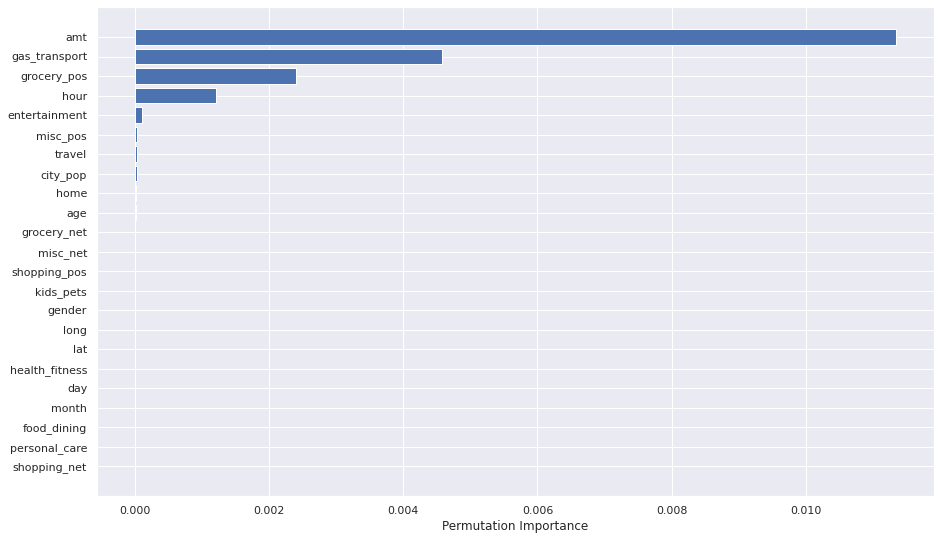

In [ ]:
# permutation based importance

perm_importance = permutation_importance(classifier, X_eval, y_eval, n_repeats = 10, random_state = 42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_holder.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")

In [ ]:
# permutation based importance for model trained on smote data
perm_importance = permutation_importance(classifier_smote, X_eval, y_eval, n_repeats = 10, random_state = 42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_holder.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")

The above permutation method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one. As we can see, `amt` and `gas_transport` are some common important features, though each evaluation method gives different importance scores.

In [ ]:
# we can also make use of SHAP feature importance
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_eval)

explainer_smote = shap.TreeExplainer(classifier_smote)
shap_values_smote = explainer_smote.shap_values(X_eval)

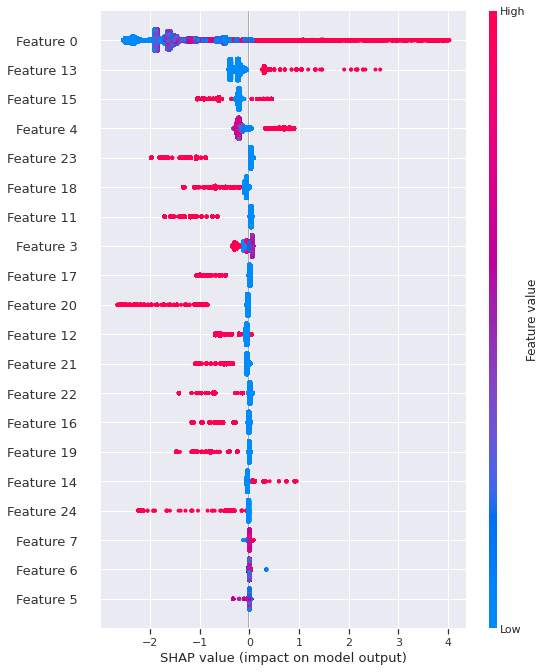

In [ ]:
shap.summary_plot(shap_values, X_eval)

As we can see, amount of transaction show the greatest effect on whether a transaction will be fraudulent, as most gravitate to the positive plane. Amt has a high positive contribution when its values are high, and a relatively low contribution on low values. Age has more effect on some transactions than others, we can further view this from a local perspective.The feature lat and city_pop has almost no contribution to the prediction, whether its values are high or low.

We can use the feature importances scores calculated from the training dataset, and transform the dataset into a subset with selected features.
After feature selection, we train a model from the selected subset of features, then evaluate the model on the testset, subject to the same feature selection scheme. Since model trained on imbalanced dataset gave the best result above, we will evaluate the test set using this model.


In [ ]:
# For instance, we use feature importance scores as thresholds, and observe how metrics score improves with appropriate features.
# However, due to computational complexity we will not run it here.
thresholds = np.sort(classifier.feature_importances_)
# for thresh in thresholds:
# 	# select features using threshold
# 	selection = SelectFromModel(classifier, threshold=thresh, prefit=True)
# 	select_X_xgb = selection.transform(X_xgb)
# 	select_X_test = selection.transform(X_test_xgb)
 
# 	# train model
# 	selection_model = XGBClassifier()
# 	selection_model.fit(select_X_xgb, y_train)
# 	# eval model
# 	predictions = selection_model.predict(select_X_test)


In [ ]:
# For more explanability:
# visualise individual base learner decision trees in trained XGBoost model, first 2 at index 1
plt.rcParams['figure.figsize'] = [50, 10]
xgb.plot_tree(classifier, num_trees = 1)


Instead, we can test out the performance of models trained by using the features we have created based on observations from EDA.

### Evaluating Performance on Different Set of Features

In [ ]:
# Defining different training feature set using categorical features created
X_xgb_2 = X_holder.copy()
X_xgb_2 = X_xgb_2.drop(['amt'], axis = 1)
X_xgb_2 = pd.concat([X_xgb_2, df['cat_amt']], axis = 1)
y_xgb_2 = df['is_fraud']

# Defining the different test dataset for XGBoost
X_test_xgb2 = X_holder_test.copy()
X_test_xgb2 = X_test_xgb2.drop(['amt'], axis = 1)
X_test_xgb2 = pd.concat([X_test_xgb2, df_test['cat_amt']], axis = 1)
y_test_xgb2 = df_test['is_fraud']

In [ ]:
# We will convert `cat_amt` into dummy variables and then concatenate the new columns into the original dataframe.
enc = OneHotEncoder()

#One hot encoding for the Training data
feature_array = enc.fit_transform(X_xgb_2[['cat_amt']]).toarray()
feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()

#New DF with OHE features for XGBoost
ohe_xgb = pd.DataFrame(feature_array, columns = feature_labels) 
X_ohe_xgb = pd.concat([X_xgb_2, ohe_xgb], axis = 1)


#One hot encoding for the testing data
feature_array_test = enc.fit_transform(X_test_xgb2[['cat_amt']]).toarray()
feature_labels_test = enc.categories_
feature_labels_test = np.array(feature_labels_test).ravel()

#DF for testing dataset
ohe_xgb_test = pd.DataFrame(feature_array_test, columns = feature_labels_test) 
X_ohe_xgb_test = pd.concat([X_test_xgb2, ohe_xgb_test], axis = 1)


In [ ]:
# Since we already one-hot encoded `cat_amt`, we remove it from the X variables.
# Removing for train
X_ohe_xgb = X_ohe_xgb.drop(['cat_amt'], axis = 'columns')
X_ohe_xgb_test = X_ohe_xgb_test.drop(['cat_amt'], axis = 'columns')

y_xgb_new = df['is_fraud'].values
y_xgb_new_test = df_test['is_fraud'].values

In [ ]:
# Splitting Train-Eval(Validation)-Test data
X_xgb_new_train, X_xgb_new_val, y_xgb_new_train, y_xgb_new_val = train_test_split(X_ohe_xgb, y_xgb_new, test_size=0.15, random_state=0)

print('X_eval: ' + str(X_xgb_new_val.shape))
print('y_eval: ' + str(y_xgb_new_val.shape))
print('X_train: ' + str(X_xgb_new_train.shape))
print('y_train: ' + str(y_xgb_new_train.shape))
print('X_test: ' + str(X_ohe_xgb_test.shape))
print('y_test: ' + str(y_xgb_new_test.shape))

In [ ]:
%%time

# imbalanced dataset with different features
classifier_new = XGBClassifier()
classifier_new.fit(X_xgb_new_train, y_xgb_new_train)

y_pred_xgb_new = classifier_new.predict(X_xgb_new_val)

print('Confusion matrix:\n', confusion_matrix(y_xgb_new_val, y_pred_xgb_new))
print(accuracy_score(y_xgb_new_val, y_pred_xgb_new))
print(classification_report(y_xgb_new_val, y_pred_xgb_new))

In [ ]:
fpr, tpr, _ = roc_curve(y_xgb_new_val,  y_pred_xgb_new)
auc = roc_auc_score(y_xgb_new_val, y_pred_xgb_new)
print(auc)

In [ ]:
# SMOTE sampling on the new dataset with different features
smote = SMOTE(random_state=42)
X_xgb_smote, y_xgb_smote = smote.fit_resample(X_xgb_new_train, y_xgb_new_train)

In [ ]:
%%time

# SMOTE
classifier_smote_new = XGBClassifier()
classifier_smote_new.fit(X_xgb_smote, y_xgb_smote)

y_pred_xgb_smote_new = classifier_smote_new.predict(X_xgb_new_val)

print('Confusion matrix:\n', confusion_matrix(y_xgb_new_val, y_pred_xgb_smote_new))
print(accuracy_score(y_xgb_new_val, y_pred_xgb_smote_new))
print(classification_report(y_xgb_new_val, y_pred_xgb_smote_new))


In [ ]:
fpr, tpr, _ = roc_curve(y_xgb_new_val,  y_pred_xgb_smote_new)
auc = roc_auc_score(y_xgb_new_val, y_pred_xgb_smote_new)
print(auc)

## XGBoost Hyperparameter tuning

Performing hyperparameter tuning helps us determine the optimal parameters to put in the best fit model. In this process, we train the model with various possible range of parameters until a best fit model is obtained.

In [ ]:
# get the list of hyperparameters used in the above trained better-peforming models
print(classifier.get_params())
print(classifier_smote.get_params())

Based on results from our research, we can also utilise Bayesian optimisation with HYPEROPT here, as this is a powerful library that search through an hyperparameter space of values to find one that minimises the loss function. (https://hyperopt.github.io/hyperopt/)

In [ ]:
# Due to computational restrictions, we will focus on three hyperparameters:
# colsample_bytree, percentage of columns to be randomly sampled for each tree.
# reg_alpha and reg_lambda which are L1 and L2 regularisation respectively, to avoid overfitting in models

# initialize domain space
space = {
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    # 'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Since we may prioritize precision or recall based on different use cases, here we use f1 score as a harmonic mean of the precision and recall
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# objective function to minimize
def objective(params):
    xgboost = XGBClassifier(seed=0, **params)
    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='f1', n_jobs=-1)
    best_score = max(scores)
    loss = - best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
trials = Trials()
# store optimal parameters that minimize loss function 
best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, 
                        max_evals = 20, trials = trials)

In [ ]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

# Print the index of the best parameters
print(best_hyperparams)
# Print the values of the best parameters
print(space_eval(space, best_hyperparams))

## XGBoost Performance on Test Data

In [ ]:
# train model using the optimised parameters
xgb_bp = XGBClassifier(seed = 0,
                       colsample_bytree = 0.7,
                       max_depth = 12,
                       reg_alpha = 1e-05,
                       reg_lambda = 1).fit(X_train, y_train)

In [ ]:
%%time

# Evaluating the XGBoost model with best parameters trained on imbalanced sampling data on test data
y_xgb_pred_imb = xgb_bp.predict(X_test)

print('Confusion matrix:\n', confusion_matrix(y_test, y_xgb_pred_imb))
print(accuracy_score(y_test, y_xgb_pred_imb))
print(classification_report(y_test, y_xgb_pred_imb))

fpr, tpr, thresholds = roc_curve(y_test, y_xgb_pred_imb)
# auc = roc_auc_score(y_test, y_xgb_pred_imb)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label="imb_tuned_params AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()


In [ ]:
# train model using the best parameters on SMOTE data
xgb_bp_smote = XGBClassifier(seed = 0,
                       colsample_bytree = 0.7,
                       max_depth = 12,
                       reg_alpha = 1e-05,
                       reg_lambda = 1).fit(X_train_smote, y_train_smote)

In [ ]:
%%time

# Evaluating the XGBoost model with best parameters trained on SMOTE sampling data on test data
y_xgb_pred_smote = xgb_bp_smote.predict(X_test)

print('Confusion matrix:\n', confusion_matrix(y_test, y_xgb_pred_smote))
print(accuracy_score(y_test, y_xgb_pred_smote))
print(classification_report(y_test, y_xgb_pred_smote))

fpr, tpr, thresholds = roc_curve(y_test, y_xgb_pred_smote)
# auc = roc_auc_score(y_test, y_xgb_pred_smote)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label="SMOTE_tuned_params AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()


In [ ]:
%%time

# Evaluating the XGBoost model trained on imbalanced data without hyperparameter tuning
y_test_pred_xgb_imb = classifier.predict(X_test)

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_pred_xgb_imb))
print(accuracy_score(y_test, y_test_pred_xgb_imb))
print(classification_report(y_test, y_test_pred_xgb_imb))

In [ ]:
# Evaluating the XGBoost model trained on imbalanced data by plotting precision-recall curve
y_xgb_pred_imb = classifier.predict_proba(X_eval)[:, 1]
y_test_pred_xgb_imb = classifier.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_eval, y_xgb_pred_imb)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label="XGBoost Train AUC = %.3f" % auc)
plt.xlabel('Recall')
plt.ylabel('Precision')

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_xgb_imb)
auc = metrics.auc(recall, precision)
plt.plot(recall, precision, label="XGBoost Test AUC = %.3f" % auc)
plt.legend()
plt.show()

In [ ]:
%%time

# Evaluating the XGBoost model trained on SMOTE sampling data
y_test_pred_xgb_smote = classifier_smote.predict(X_test)

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_pred_xgb_smote))
print(accuracy_score(y_test, y_test_pred_xgb_smote))
print(classification_report(y_test, y_test_pred_xgb_smote))

Confusion matrix:
 [[548442   5132]
 [   328   1817]]
0.990174890547201
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.26      0.85      0.40      2145

    accuracy                           0.99    555719
   macro avg       0.63      0.92      0.70    555719
weighted avg       1.00      0.99      0.99    555719



# CatBoost

CatBoost is a open-source model that uses gradient boosting algorithm on decision trees. It utilises a special framework to handle categorical features for the model. This involves permutating a set of categorical input objects into random order or transforming categorical features into numerical inputs using different statistics on combinations of cateogrical features and even combinations of categorical and numerical features. 
https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic


Upon observing that decision tree classification models have better results in terms of recall and precision, we have decided to test out the CatBoost gradient boosting model.

Since CatBoost pre-processes categorical features on the go, there is no need to do any transformation or one-hot encoding for the categorical features. Moreover, we are able to input more categorical variables such as job and day_name to test in our model.

In terms of imbalance data, balancing data would be difficult or tedious with categorical features and hence, CatBoost models have inbuilt parameters such as auto_weights and scale_weight_pos that acts as a multiplier for the weights of objects from fraudulent transactions which increases weight of the imbalance class according to the ratio.


In [ ]:
df.columns

Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'hour', 'day', 'day_name',
       'month', 'year', 'cat_amt', 'cat_age'],
      dtype='object')

In [ ]:
#Function to convert any object data to categorical for CatBoost
def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')
        
#Function to get categorical index        
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies


### Base CatBoost Model

In [ ]:
#Defining the inputs and outputs of model
#Since CatBoost does its own encoding, we need not use the one-hot encoding dataframe for this model.
#Using the baseline features found from EDA

#Defining the training variables for CatBoost
X_cb_train_prep = df.copy()
y_cb_train_prep = df.copy()
X_cb_train_prep = X_cb_train_prep[['amt','gender','city_pop','month','day','hour','age','lat','long','category']]
y_cb_train_prep = y_cb_train_prep['is_fraud'] #output variable

#Defining the testing variables for CatBoost
X_cb_test = df_test.copy()
y_cb_test = df_test.copy()
X_cb_test = X_cb_test[['amt','gender','city_pop','month','day','hour','age','lat','long','category']]
y_cb_test = y_cb_test['is_fraud'] #output variable

In [ ]:
#DF for collection of results
cb_result = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#Get categorical_indices
categorical_indicies = get_categorical_indicies(X_cb_train_prep)

In [ ]:
#Defining the Categorical Features for model
cat= ['category', 'gender']

#Splitting Validation and Training data for model
X_cb_train, X_cb_eval, y_cb_train, y_cb_eval = train_test_split(X_cb_train_prep, y_cb_train_prep, test_size = 0.15, random_state = 0)


In [ ]:
# First, trying out imbalanced data on CatBoost for comparison
# Since this is a binary classification, it'll use log loss as the loss function
cb_classifier = CatBoostClassifier(loss_function = 'Logloss')
cb_classifier.fit(X_cb_train, y_cb_train, 
                  cat_features = cat,
                  verbose = False
                 )

In [ ]:
#Prediction on validation data first
cb_pred = cb_classifier.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred))
print('R2 score:', r2_score(y_cb_eval, cb_pred))
print('Logloss: ', log_loss(y_cb_eval, cb_pred))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred))
print(classification_report(y_cb_eval, cb_pred))

Accuracy: 0.9989717329384787
R2 score: 0.8221310591546189
Logloss:  0.035515229997081704
Confusion matrix:
 [[193336     35]
 [   165    966]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.97      0.85      0.91      1131

    accuracy                           1.00    194502
   macro avg       0.98      0.93      0.95    194502
weighted avg       1.00      1.00      1.00    194502



In [ ]:
#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval,  cb_pred)
auc = roc_auc_score(y_cb_eval, cb_pred)
cb_result = cb_result.append({'classifiers': 'imbalanced', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

#### Oversampling

In [ ]:
# SMOTE(NC)
# Given that SMOTE only works for non-categorical data, we will use SMOTENC for the CatBoost Model since it can work with categorical data
smote_nc = SMOTENC(categorical_features = categorical_indicies, random_state = 0)
X_cb_smote, y_cb_smote = smote_nc.fit_resample(X_cb_train, y_cb_train)

In [ ]:
#May take awhile to build model
cb_classifier_smote = CatBoostClassifier(loss_function = 'Logloss')
cb_classifier_smote.fit(X_cb_smote, y_cb_smote, 
                          cat_features = cat,
                          verbose = False
                        )

In [ ]:
#Prediction on validation data first
cb_pred_smote = cb_classifier_smote.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred_smote))
print('R2 score:', r2_score(y_cb_eval, cb_pred_smote))
print('Logloss: ', log_loss(y_cb_eval, cb_pred_smote))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred_smote))
print(classification_report(y_cb_eval, cb_pred_smote))

#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval,  cb_pred_smote)
auc = roc_auc_score(y_cb_eval, cb_pred_smote)
cb_result = cb_result.append({'classifiers': 'SMOTENC', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

Accuracy: 0.9953985048996925
R2 score: 0.20403648971691934
Logloss:  0.15893331970558947
Confusion matrix:
 [[192566    805]
 [    90   1041]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.56      0.92      0.70      1131

    accuracy                           1.00    194502
   macro avg       0.78      0.96      0.85    194502
weighted avg       1.00      1.00      1.00    194502



#### Undersampling

In [ ]:
#Simple undersampling that works with Categorical data
cb_train_df = pd.concat([X_cb_train_prep, y_cb_train_prep], axis = 1)
cb_frauds = cb_train_df[cb_train_df['is_fraud'] == 1]
cb_non_frauds = cb_train_df[cb_train_df['is_fraud'] == 0]
cb_non_frauds = cb_non_frauds.sample(n = len(cb_frauds), random_state = 0)

cb_train_df = pd.concat([cb_frauds, cb_non_frauds], axis = 0)
X_cb_under = cb_train_df.drop('is_fraud', axis = 1)
y_cb_under = cb_train_df['is_fraud']

#to check
print(len(cb_non_frauds), len(cb_frauds))
print(len(X_cb_under), len(y_cb_under))

7506 7506
15012 15012


In [ ]:
cb_classifier_under = CatBoostClassifier(loss_function = 'Logloss')
cb_classifier_under.fit(X_cb_under, y_cb_under, 
                          cat_features = cat,
                          verbose = False
                        )

In [ ]:
#Prediction on validation data first
cb_pred_under = cb_classifier_under.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred_under))
print('R2 score:', r2_score(y_cb_eval, cb_pred_under))
print('Logloss: ', log_loss(y_cb_eval, cb_pred_under))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred_under))
print(classification_report(y_cb_eval, cb_pred_under))

#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval, cb_pred_under)
auc = roc_auc_score(y_cb_eval, cb_pred_under)
cb_result = cb_result.append({'classifiers': 'Undersampling', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

Accuracy: 0.9797637042292624
R2 score: -2.500460755837101
Logloss:  0.6989530591328837
Confusion matrix:
 [[189439   3932]
 [     4   1127]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    193371
           1       0.22      1.00      0.36      1131

    accuracy                           0.98    194502
   macro avg       0.61      0.99      0.68    194502
weighted avg       1.00      0.98      0.99    194502



#### CatBoost's scale_pos_weight 

In [ ]:
#Keeping track of number of frauds
y_cb_train.value_counts()

0    1095798
1       6375
Name: is_fraud, dtype: int64

In [ ]:
#Scale_pos_weights, for imbalanced data set use the weight multiplier (sum_negative)/(sum_positive)
# to counter a super imbalanced data, we use squareroot of the formula
math.sqrt((1095798/6375))

13.110678180511533

##### scale_pos_weight = 13

In [ ]:
# Since this is a binary classification, it'll use log loss as the loss function
cb_classifier_pos13 = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 13)
cb_classifier_pos13.fit(X_cb_train, y_cb_train, 
                  cat_features = cat,
                  verbose = False
                 )

In [ ]:
#Prediction on validation data first
cb_pred_pos13 = cb_classifier_pos13.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred_pos13))
print('R2 score:', r2_score(y_cb_eval, cb_pred_pos13))
print('Logloss: ', log_loss(y_cb_eval, cb_pred_pos13))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred_pos13))
print(classification_report(y_cb_eval, cb_pred_pos13))

Accuracy: 0.9987557968555594
R2 score: 0.7847785815770888
Logloss:  0.04297383795746915
Confusion matrix:
 [[193229    142]
 [   100   1031]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.88      0.91      0.89      1131

    accuracy                           1.00    194502
   macro avg       0.94      0.96      0.95    194502
weighted avg       1.00      1.00      1.00    194502



In [ ]:
#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval,  cb_pred_pos13)
auc = roc_auc_score(y_cb_eval, cb_pred_pos13)
cb_result = cb_result.append({'classifiers': 'scale_weight_pos=13', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

##### scale_pos_weight = 5 (Test)

In [ ]:
cb_classifier_pos5 = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 5)
cb_classifier_pos5.fit(X_cb_train, y_cb_train, 
                  cat_features = cat,
                  verbose = False
                 )

In [ ]:
#Prediction on validation data first
cb_pred_pos5 = cb_classifier_pos5.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred_pos5))
print('R2 score:', r2_score(y_cb_eval, cb_pred_pos5))
print('Logloss: ', log_loss(y_cb_eval, cb_pred_pos5))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred_pos5))
print(classification_report(y_cb_eval, cb_pred_pos5))

In [ ]:
#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval,  cb_pred_pos5)
auc = roc_auc_score(y_cb_eval, cb_pred_pos5)
cb_result = cb_result.append({'classifiers': 'scale_weight_pos=5', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

##### scale_pos_weight = 3

In [ ]:
# Since this is a binary classification, it'll use log loss as the loss function
cb_classifier_pos3 = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 3)
cb_classifier_pos3.fit(X_cb_train, y_cb_train, 
                  cat_features = cat,
                  verbose = False
                 )

In [ ]:
#Prediction on validation data first
cb_pred_pos3 = cb_classifier_pos3.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, cb_pred_pos3))
print('R2 score:', r2_score(y_cb_eval, cb_pred_pos3))
print('Logloss: ', log_loss(y_cb_eval, cb_pred_pos3))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, cb_pred_pos3))
print(classification_report(y_cb_eval, cb_pred_pos3))

Accuracy: 0.9989100369147875
R2 score: 0.811458922703896
Logloss:  0.03764630371474819
Confusion matrix:
 [[193295     76]
 [   136    995]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.93      0.88      0.90      1131

    accuracy                           1.00    194502
   macro avg       0.96      0.94      0.95    194502
weighted avg       1.00      1.00      1.00    194502



In [ ]:
#Keeping track of ROC metrics
fpr, tpr, _ = roc_curve(y_cb_eval,  cb_pred_pos3)
auc = roc_auc_score(y_cb_eval, cb_pred_pos3)
cb_result = cb_result.append({'classifiers': 'scale_weight_pos=3', 'fpr': fpr, 'tpr': tpr, 'auc': auc}, ignore_index=True)

#### ROC Curve comparison

In [ ]:
#define metrics
cb_result.set_index('classifiers', inplace=True)

#create ROC curve for CatBoost with different sampling methods
fig = plt.figure(figsize=(8,6))
for i in cb_result.index:
    plt.plot(cb_result.loc[i]['fpr'], 
             cb_result.loc[i]['tpr'],
             label="{}, AUC={:.5f}".format(i, cb_result.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Based on the test for the different sampling methods, we found that using the model's in-built scale_weight_pos =3 gives the optimal results overall, in terms of the accuracy, logloss, f1-score, R2 score and AUC. In this case, we prioritise R2 score since we would want a model to better fit a data.

Hence, we will be using the model with scale_weight_pos = 3 for feature importance

### CatBoost Feature Importance

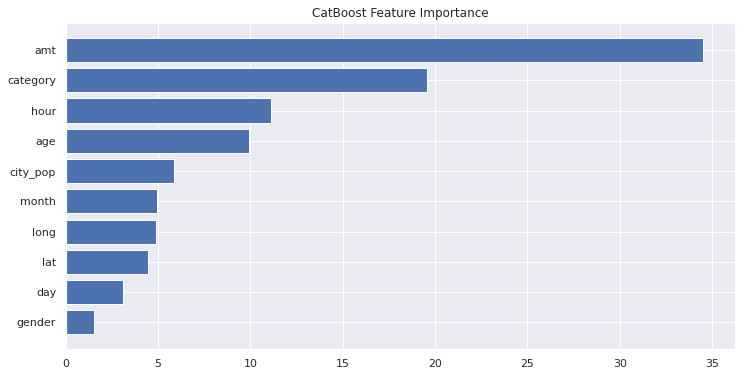

In [ ]:
#Tree-based (for Gini) importance
feature_importance = cb_classifier_pos3.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_cb_train_prep.columns)[sorted_idx])
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
perm_importance = permutation_importance(cb_classifier_pos3, X_cb_eval, y_cb_eval, n_repeats=10, random_state=0)

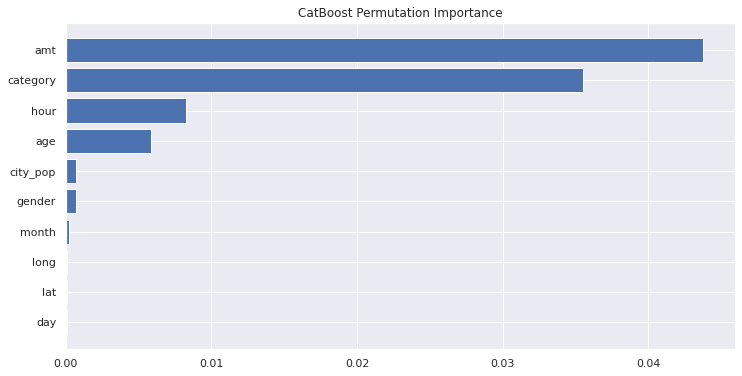

In [ ]:
#Permutation Importance
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cb_train_prep.columns)[sorted_idx])
plt.title('CatBoost Permutation Importance')
plt.show()

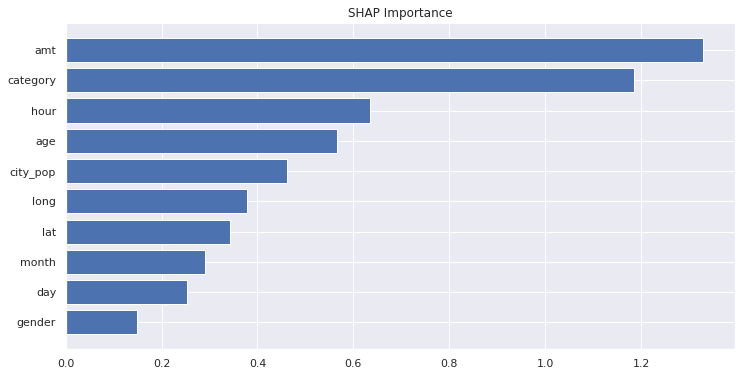

In [ ]:
#Shap Absolute value
explainer = shap.Explainer(cb_classifier_pos3)
shap_values = explainer(X_cb_eval)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cb_train_prep.columns)[sorted_idx])
plt.title('SHAP Importance')
plt.show()

In [ ]:
shap_values = explainer.shap_values(Pool(X_cb_train, y_cb_train, cat_features = cat))

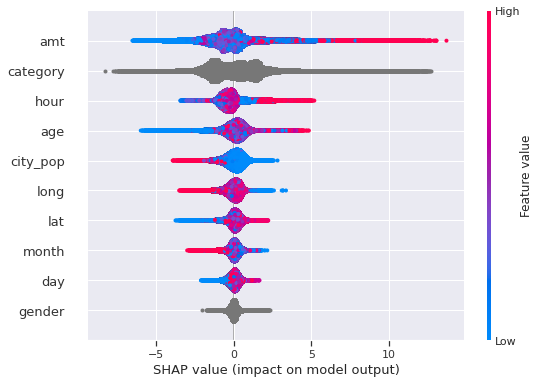

In [ ]:
shap.summary_plot(shap_values, X_cb_train)

### Training (Tuning) the model

In [ ]:
#Grid Search parameters
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5],
        'iterations': [50, 100, 150]
       }
train_dataset = Pool(X_cb_train, y_cb_train, cat_features = categorical_indicies)

In [ ]:
#cb_model = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 3)
#cb_model.grid_search(grid, train_dataset)
#cb_model.get_params()
### Best
## {'loss_function': 'Logloss',
##  'scale_pos_weight': 3,
##  'depth': 10,
##  'l2_leaf_reg': 5,
##  'iterations': 150,
##  'learning_rate': 0.1}

In [ ]:
#Evaluating the CatBoost model trained on scale_weight_pos = 3
selected_cb_model = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 3,
                                      depth = 10, l2_leaf_reg= 5, iterations = 150, learning_rate = 0.1)
selected_cb_model.fit(X_cb_train, y_cb_train, 
                  cat_features = cat,
                  verbose = False)
y_cb_eval_pred = selected_cb_model.predict(X_cb_eval)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_eval, y_cb_eval_pred))
print('R2 score:', r2_score(y_cb_eval, y_cb_eval_pred))
print('Logloss: ', log_loss(y_cb_eval, y_cb_eval_pred))

print('Confusion matrix:\n', confusion_matrix(y_cb_eval, y_cb_eval_pred))
print(classification_report(y_cb_eval, y_cb_eval_pred))
# Based on the results, we can see that the model has a relatively high accuracy on the test data
# and also a really low Log loss. However, the R2 score shows a negative value which shows that the data is not fitted well.

Accuracy: 0.9985552847785627
R2 score: 0.7500941381122395
Logloss:  0.04989905775541614
Confusion matrix:
 [[193283     88]
 [   193    938]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193371
           1       0.91      0.83      0.87      1131

    accuracy                           1.00    194502
   macro avg       0.96      0.91      0.93    194502
weighted avg       1.00      1.00      1.00    194502



In [ ]:
#Evaluating the CatBoost model trained on scale_weight_pos = 3
y_cb_test_pred = selected_cb_model.predict(X_cb_test)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_test, y_cb_test_pred))
print('R2 score:', r2_score(y_cb_test, y_cb_test_pred))
print('Logloss: ', log_loss(y_cb_test, y_cb_test_pred))

print('Confusion matrix:\n', confusion_matrix(y_cb_test, y_cb_test_pred))
print(classification_report(y_cb_test, y_cb_test_pred))
# Based on the results, we can see that the model has a relatively high accuracy on the test data
# and also a really low Log loss. However, the R2 score shows a negative value which shows that the data is not fitted well.

Accuracy: 0.9947671395075569
R2 score: -0.36096409259961093
Logloss:  0.18073973371290378
Confusion matrix:
 [[551395   2179]
 [   729   1416]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.39      0.66      0.49      2145

    accuracy                           0.99    555719
   macro avg       0.70      0.83      0.75    555719
weighted avg       1.00      0.99      1.00    555719



### CatBoost: Testing with different Features

In this section, we will be testing the other engineered or categorical features with our suited CatBoost model from the earlier portion

In [ ]:
#[['merch_lat','merch_long','category','amt','lat','long','city_pop','cat_age','hour','day_name','month','is_fraud','job']]
#Defining the training variables for CatBoost
X_cb_train_prep2 = df.copy()
y_cb_train_prep2 = df.copy()

X_cb_train_prep2 = X_cb_train_prep2[['category','amt','lat','long','city_pop','cat_age','hour','day_name','month']]
y_cb_train_prep2 = y_cb_train_prep2['is_fraud'] #output variable

#Defining the testing variables for CatBoost
X_cb_test2 = df_test.copy()
y_cb_test2 = df_test.copy()

X_cb_test2 = X_cb_test2[['category','amt','lat','long','city_pop','cat_age','hour','day_name','month']]
y_cb_test2 = y_cb_test2['is_fraud'] #output variable

In [ ]:
#Converting X for train and test input features to categorical
convert_cats(X_cb_train_prep2)
convert_cats(X_cb_test2)

#Get categorical_indices
categorical_indicies = get_categorical_indicies(X_cb_train_prep2)

In [ ]:
X_cb_train_prep2.info() #To check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   category  1296675 non-null  category
 1   amt       1296675 non-null  float64 
 2   lat       1296675 non-null  float64 
 3   long      1296675 non-null  float64 
 4   city_pop  1296675 non-null  int64   
 5   cat_age   1296675 non-null  category
 6   hour      1296675 non-null  int64   
 7   day_name  1296675 non-null  category
 8   month     1296675 non-null  int64   
dtypes: category(3), float64(3), int64(3)
memory usage: 63.1 MB


In [ ]:
# Based on our earlier training, we found that using scale_weight_pos provides optimal model performance and hence, we will be using that as 
# the sampling method

#Splitting Validation and Training data for model
X_cb_train, X_cb_eval, y_cb_train, y_cb_eval = train_test_split(X_cb_train_prep2, y_cb_train_prep2, test_size = 0.15, random_state = 0)

In [ ]:
# GridSearch for CatBoost, done offline
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5,],
#         'iterations': [50, 100, 150]
#        }

train_dataset = Pool(X_cb_train, y_cb_train, cat_features = categorical_indicies)

In [ ]:
# cat_model.get_params()

In [ ]:
cb_test_model = CatBoostClassifier(loss_function = 'Logloss', scale_pos_weight = 3,
                                  depth = 10, l2_leaf_reg= 5, iterations = 150, learning_rate = 0.1)

cb_test_model.fit(X_cb_train, y_cb_train, cat_features = categorical_indicies,
                  verbose = False)

In [ ]:
#Evaluating the CatBoost model trained on scale_weight_pos = 3
new_y_cb_test_pred = cb_test_model.predict(X_cb_test2)

#Catboost Metrics
print("Accuracy:", accuracy_score(y_cb_test2, new_y_cb_test_pred))
print('R2 score:', r2_score(y_cb_test2, new_y_cb_test_pred))
print('Logloss: ', log_loss(y_cb_test2, new_y_cb_test_pred))

print('Confusion matrix:\n', confusion_matrix(y_cb_test2, new_y_cb_test_pred))
print(classification_report(y_cb_test2, new_y_cb_test_pred))
## We observed that cat_age did improve our overall model performance instead of 'age'

Accuracy: 0.9959241991006246
R2 score: -0.060035649841168715
Logloss:  0.14077553273338492
Confusion matrix:
 [[551936   1638]
 [   627   1518]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.48      0.71      0.57      2145

    accuracy                           1.00    555719
   macro avg       0.74      0.85      0.79    555719
weighted avg       1.00      1.00      1.00    555719



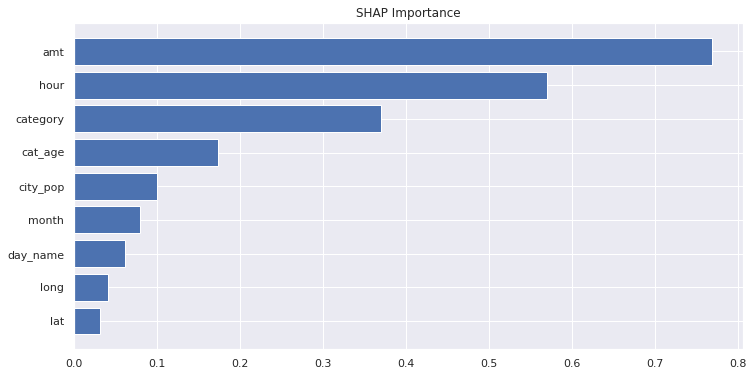

In [ ]:
#Shap Absolute value
explainer = shap.Explainer(cb_test_model)
shap_values = explainer(X_cb_test2)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cb_train.columns)[sorted_idx])
plt.title('SHAP Importance')
plt.show()

# Conclusion

From this project, we gained experience implementing fraud detection pipeline through analysis and selection of appropriate machine learning tools. With an improved business understanding of financial frauds, we evaluated models based on their statistical accuracy and interpretability. Other characteristics we considered include operational efficiency and economical usage, which can be more applicable in real life context. 

As frauds evolve over time, the techniques used for prevention should be adapted continuously. In this project, we mainly focused on data-driven analytics. In real life, however, we assume that these processes can be combined with expert domain knowledge to be more effective. Moreover, depending on the stakeholders for the application of these techniques, greater transparency of the model and explainability of the machine learning process could be involved to increase the trust and reliability of the stakeholders towards the results of these predictions.

Through the various model experimentations, we learnt different methodologies to train and improve our models such as data engineering and balancing. Additionally, we learnt the importance of interpretability and qualitative reflections. Some models gave interesting insights as to how fraud data could be accurately detected, while other models explained how the data behaves according to the context. With this knowledge, we aim to utilize our research insights to make a difference in minimizing fraud in the real world.

